# Important Modules

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats.mstats import winsorize
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import ttest_ind, f_oneway

In [2]:

# Define the directory where raw CSV files are stored
raw_folder_path = '/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/raw/Raw data ESG data 2025Feb'  # Update this if needed

# Define the directory where processed files should be saved
processed_folder_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed"

# Ensure the processed folder exists
os.makedirs(processed_folder_path, exist_ok=True)

# List of ESG raw data files
csv_files = [
    "esg_raw_data_on_corporations_myu_5.csv",
    "esg_raw_data_on_corporations_myu_2.csv",
    "esg_raw_data_on_corporations_1.csv",
    "esg_raw_data_on_corporations_myu_4.csv",
    "esg_raw_data_on_corporations_myu_3.csv",
    "esg_raw_data_on_corporations_7.csv",
    "esg_raw_data_on_corporations_6.csv"
]

# Initialize empty lists for E, S, and G dataframes
e_dataframes = []
s_dataframes = []
g_dataframes = []

# Loop through each file and read the data
for filename in csv_files:
    file_path = os.path.join(raw_folder_path, filename)

    try:
        # Read CSV file with correct delimiter
        df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

        # Ensure 'pillar' column exists before filtering
        if 'pillar' in df.columns:
            e_dataframes.append(df[df['pillar'] == 'E'])
            s_dataframes.append(df[df['pillar'] == 'S'])
            g_dataframes.append(df[df['pillar'] == 'G'])

            print(f"Processed {filename}: E({len(e_dataframes[-1])}), S({len(s_dataframes[-1])}), G({len(g_dataframes[-1])})")
        else:
            print(f"Skipping {filename} - 'pillar' column missing.")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Combine all files into one per category
df_e = pd.concat(e_dataframes, ignore_index=True)
df_s = pd.concat(s_dataframes, ignore_index=True)
df_g = pd.concat(g_dataframes, ignore_index=True)

# Save the new CSV files in the processed directory
df_e.to_csv(os.path.join(processed_folder_path, "esg_environmental_data.csv"), index=False, sep='|')
df_s.to_csv(os.path.join(processed_folder_path, "esg_social_data.csv"), index=False, sep='|')
df_g.to_csv(os.path.join(processed_folder_path, "esg_governance_data.csv"), index=False, sep='|')

print("CSV files saved successfully in the processed folder:")
print(f"- Environmental Data: {len(df_e)} rows")
print(f"- Social Data: {len(df_s)} rows")
print(f"- Governance Data: {len(df_g)} rows")


Processed esg_raw_data_on_corporations_myu_5.csv: E(396333), S(51959), G(74546)
Processed esg_raw_data_on_corporations_myu_2.csv: E(894601), S(196542), G(231277)
Processed esg_raw_data_on_corporations_1.csv: E(1269834), S(768008), G(726410)
Processed esg_raw_data_on_corporations_myu_4.csv: E(624877), S(74975), G(112890)
Processed esg_raw_data_on_corporations_myu_3.csv: E(767791), S(100980), G(155926)
Processed esg_raw_data_on_corporations_7.csv: E(50502), S(14844), G(21025)
Processed esg_raw_data_on_corporations_6.csv: E(190863), S(25985), G(40755)
CSV files saved successfully in the processed folder:
- Environmental Data: 4194801 rows
- Social Data: 1233293 rows
- Governance Data: 1362829 rows


In [ ]:

# Define file paths
processed_folder_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed"
metric_summary_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/raw/metric_summary.csv"
industry_file_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/raw/industry.csv"  # Using the updated industry.csv file

# Load the Metric Summary file
metric_summary = pd.read_csv(metric_summary_path)

# Load the Industry file
industry_data = pd.read_csv(industry_file_path)

# Ensure 'perm_id' and 'Industry' columns exist
if 'perm_id' not in industry_data.columns or 'Industry' not in industry_data.columns or 'Company Name' not in industry_data.columns:
    raise ValueError("Industry file must contain 'perm_id', 'Industry', and 'Company Name' columns.")

# Load processed ESG files
e_file = os.path.join(processed_folder_path, "esg_environmental_data.csv")
s_file = os.path.join(processed_folder_path, "esg_social_data.csv")
g_file = os.path.join(processed_folder_path, "esg_governance_data.csv")

df_e = pd.read_csv(e_file, delimiter='|', encoding='utf-8')
df_s = pd.read_csv(s_file, delimiter='|', encoding='utf-8')
df_g = pd.read_csv(g_file, delimiter='|', encoding='utf-8')

# Merge industry data into ESG datasets using 'perm_id' first
df_e = df_e.merge(industry_data[['perm_id', 'Industry']], on='perm_id', how='left')
df_s = df_s.merge(industry_data[['perm_id', 'Industry']], on='perm_id', how='left')
df_g = df_g.merge(industry_data[['perm_id', 'Industry']], on='perm_id', how='left')

# If 'Industry' is missing, try matching with 'Company Name'
df_e = df_e.merge(industry_data[['Company Name', 'Industry']], left_on='company_name', right_on='Company Name', how='left', suffixes=('_perm', '_name'))
df_s = df_s.merge(industry_data[['Company Name', 'Industry']], left_on='company_name', right_on='Company Name', how='left', suffixes=('_perm', '_name'))
df_g = df_g.merge(industry_data[['Company Name', 'Industry']], left_on='company_name', right_on='Company Name', how='left', suffixes=('_perm', '_name'))

# Fill missing values: Use 'Industry_name' if 'Industry' is still NaN
df_e.loc[:, 'Industry'] = df_e['Industry_perm'].fillna(df_e['Industry_name'])
df_s.loc[:, 'Industry'] = df_s['Industry_perm'].fillna(df_s['Industry_name'])
df_g.loc[:, 'Industry'] = df_g['Industry_perm'].fillna(df_g['Industry_name'])

# Drop extra columns after merging
df_e.drop(columns=['Industry_perm', 'Industry_name', 'Company Name'], inplace=True, errors='ignore')
df_s.drop(columns=['Industry_perm', 'Industry_name', 'Company Name'], inplace=True, errors='ignore')
df_g.drop(columns=['Industry_perm', 'Industry_name', 'Company Name'], inplace=True, errors='ignore')

# Ensure no missing industries
df_e.loc[:, 'Industry'] = df_e['Industry'].fillna("Unknown")
df_s.loc[:, 'Industry'] = df_s['Industry'].fillna("Unknown")
df_g.loc[:, 'Industry'] = df_g['Industry'].fillna("Unknown")

# Split the datasets using the Metric Summary
e_risk_metrics = metric_summary[metric_summary['category'] == 'Environmental Risk']['metric_name'].tolist()
e_opportunity_metrics = metric_summary[metric_summary['category'] == 'Environmental Opportunity']['metric_name'].tolist()

df_e_risk = df_e[df_e['metric_name'].isin(e_risk_metrics)]
df_e_opportunity = df_e[df_e['metric_name'].isin(e_opportunity_metrics)]

s_risk_metrics = metric_summary[metric_summary['category'] == 'Social Risk']['metric_name'].tolist()
s_opportunity_metrics = metric_summary[metric_summary['category'] == 'Social Opportunity']['metric_name'].tolist()

df_s_risk = df_s[df_s['metric_name'].isin(s_risk_metrics)]
df_s_opportunity = df_s[df_s['metric_name'].isin(s_opportunity_metrics)]

g_risk_metrics = metric_summary[metric_summary['category'] == 'Governance Risk']['metric_name'].tolist()
g_opportunity_metrics = metric_summary[metric_summary['category'] == 'Governance Opportunity']['metric_name'].tolist()

df_g_risk = df_g[df_g['metric_name'].isin(g_risk_metrics)]
df_g_opportunity = df_g[df_g['metric_name'].isin(g_opportunity_metrics)]

# Save the final split files in the processed directory
df_e_risk.to_csv(os.path.join(processed_folder_path, "esg_environmental_risk.csv"), index=False, sep='|')
df_e_opportunity.to_csv(os.path.join(processed_folder_path, "esg_environmental_opportunity.csv"), index=False, sep='|')

df_s_risk.to_csv(os.path.join(processed_folder_path, "esg_social_risk.csv"), index=False, sep='|')
df_s_opportunity.to_csv(os.path.join(processed_folder_path, "esg_social_opportunity.csv"), index=False, sep='|')

df_g_risk.to_csv(os.path.join(processed_folder_path, "esg_governance_risk.csv"), index=False, sep='|')
df_g_opportunity.to_csv(os.path.join(processed_folder_path, "esg_governance_opportunity.csv"), index=False, sep='|')

# Verify missing industry values
missing_e = df_e['Industry'].isnull().sum()
missing_s = df_s['Industry'].isnull().sum()
missing_g = df_g['Industry'].isnull().sum()

print("🔍 Industry Data Final Verification:")
print(f"Environmental Dataset (E) - Missing Industries: {missing_e}")
print(f"Social Dataset (S) - Missing Industries: {missing_s}")
print(f"Governance Dataset (G) - Missing Industries: {missing_g}")

print("\n All missing industry values have been filled. Files updated successfully.")


🔍 Industry Data Final Verification:
Environmental Dataset (E) - Missing Industries: 0
Social Dataset (S) - Missing Industries: 0
Governance Dataset (G) - Missing Industries: 0

✅ All missing industry values have been filled. Files updated successfully.


In [ ]:
# Define file paths
processed_folder_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed"

# List of files to clean
files_to_clean = [
    "esg_environmental_risk.csv",
    "esg_environmental_opportunity.csv",
    "esg_social_risk.csv",
    "esg_social_opportunity.csv",
    "esg_governance_risk.csv",
    "esg_governance_opportunity.csv"
]

# Columns to remove
columns_to_remove = ["metric_unit", "headquarter_country", "reported_date", "provider_name"]

# Process each file
for filename in files_to_clean:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    # Extract year from 'metric_year' column
    if 'metric_year' in df.columns:
        df['year'] = pd.to_datetime(df['metric_year'], errors='coerce').dt.year  # Extract year
        df.drop(columns=['metric_year'], inplace=True)  # Remove original column after extraction

    # Drop specified columns if they exist
    df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True, errors='ignore')

    # Drop columns that are completely empty (100% missing)
    df_cleaned = df.dropna(axis=1, how='all')

    # Save the cleaned file with `_cleaned` suffix
    cleaned_file_path = os.path.join(processed_folder_path, filename.replace('.csv', '_cleaned.csv'))
    df_cleaned.to_csv(cleaned_file_path, index=False, sep='|')

    print(f"Cleaned file saved: {cleaned_file_path} (Rows: {len(df_cleaned)})")

print("\n🎯 Cleaning process complete! All cleaned files are now stored in the processed folder.")

✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_environmental_risk_cleaned.csv (Rows: 3203808)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_environmental_opportunity_cleaned.csv (Rows: 754598)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_social_risk_cleaned.csv (Rows: 740717)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_social_opportunity_cleaned.csv (Rows: 496681)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_governance_risk_cleaned.csv (Rows: 257996)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~appl

In [5]:
# Define file path
file_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_social_opportunity_cleaned.csv"

# Read the CSV file using the correct delimiter '|'
df_soc_oppr_cleaned = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

# Display the first few rows
print(df_soc_oppr_cleaned.head())

      company_name     perm_id data_type  disclosure  \
0  Landsbankinn hf  5000632996     float    REPORTED   
1  Landsbankinn hf  5000632996       int    REPORTED   
2  Landsbankinn hf  5000632996       int    REPORTED   
3  Landsbankinn hf  5000632996       int    REPORTED   
4  Landsbankinn hf  5000632996       int  CALCULATED   

                                  metric_description  \
0                     Percentage of women employees.   
1  Has the company established a program or an in...   
2  Has the company established a program or an in...   
3  Does the company have a provision or comply wi...   
4  Does the company claim to have an ISO 14000 or...   

                metric_name  metric_value  nb_points_of_observations pillar  \
0            WOMENEMPLOYEES         54.68                        293      S   
1  ANIMAL_TESTING_REDUCTION          0.00                        293      S   
2  ANIMAL_TESTING_REDUCTION          0.00                        293      S   
3  WHISTLE

In [6]:
# List of cleaned files
files_to_visualize = [
    "esg_environmental_risk_cleaned.csv",
    "esg_environmental_opportunity_cleaned.csv",
    "esg_social_risk_cleaned.csv",
    "esg_social_opportunity_cleaned.csv",
    "esg_governance_risk_cleaned.csv",
    "esg_governance_opportunity_cleaned.csv"
]

# Set visual style
sns.set_style("whitegrid")


 Generating visualizations for: esg_environmental_risk_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


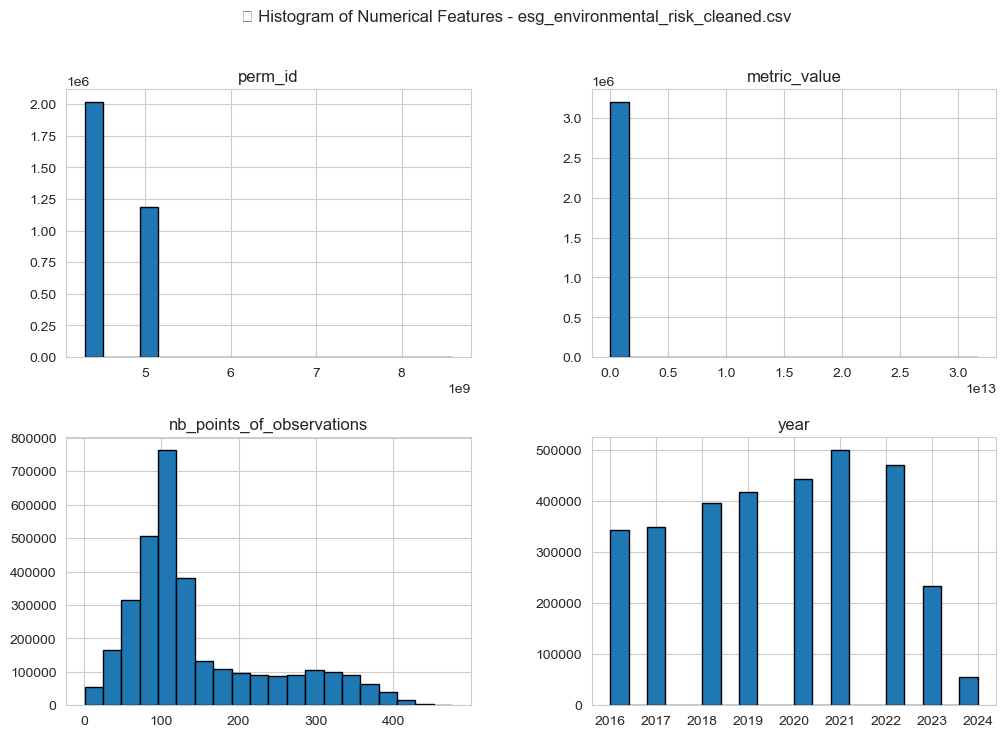


 Generating visualizations for: esg_environmental_opportunity_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


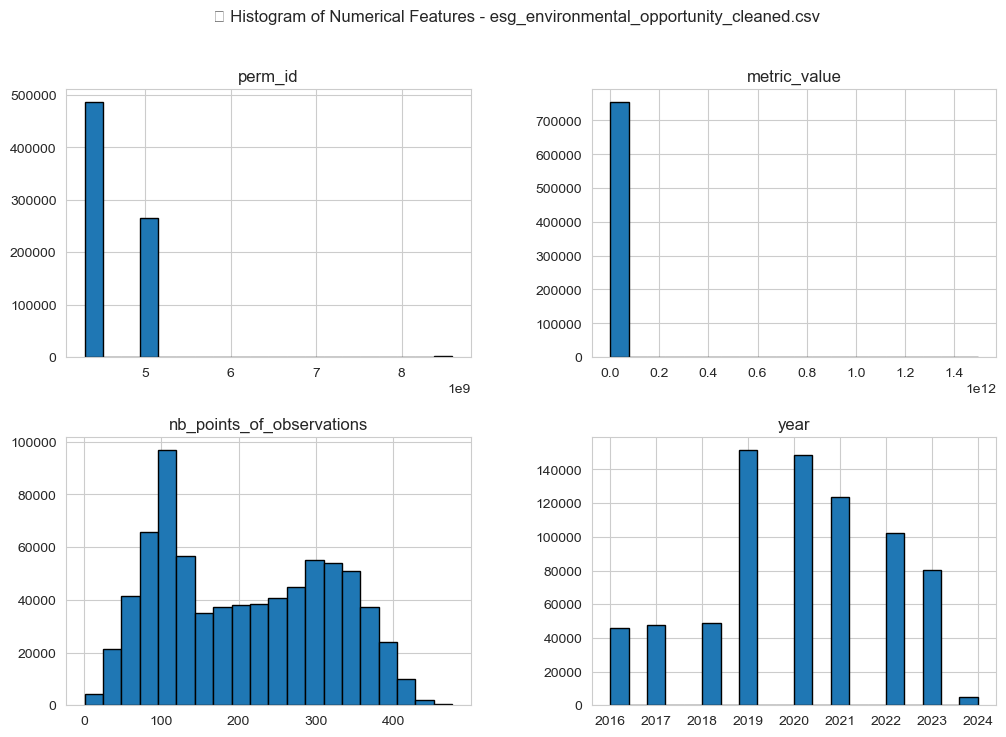


 Generating visualizations for: esg_social_risk_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


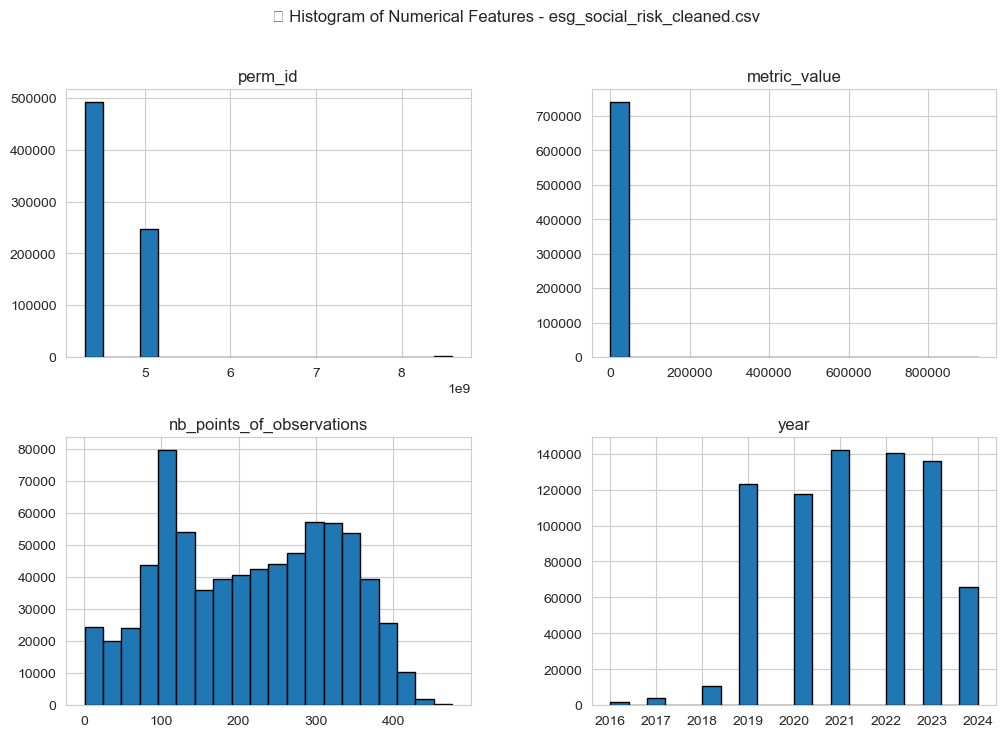


 Generating visualizations for: esg_social_opportunity_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


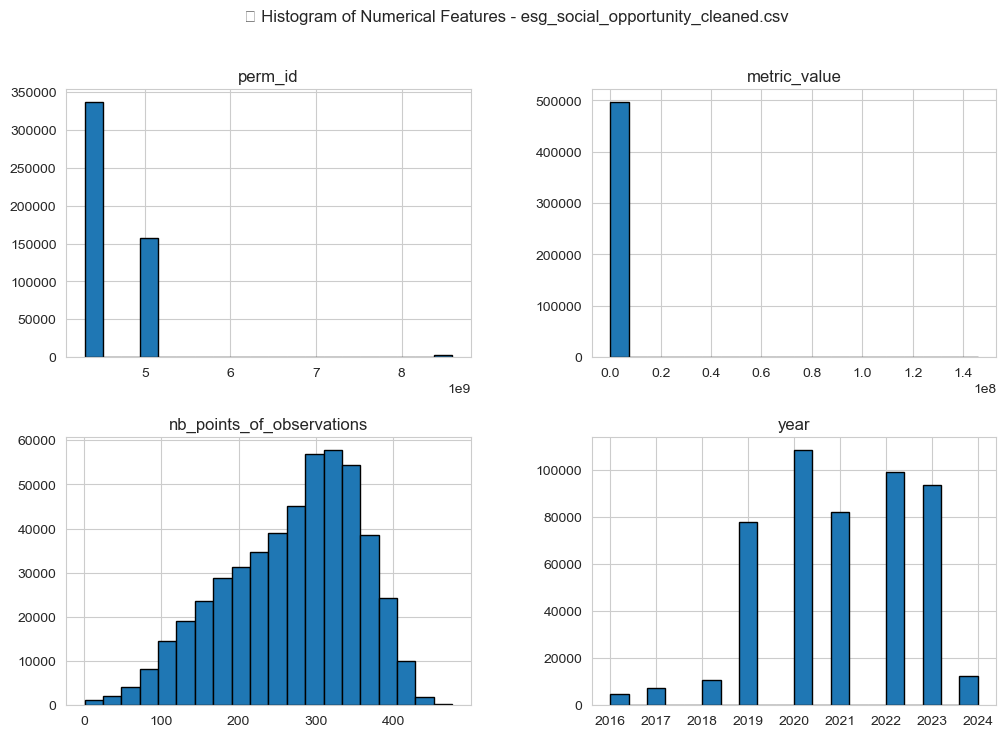


 Generating visualizations for: esg_governance_risk_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


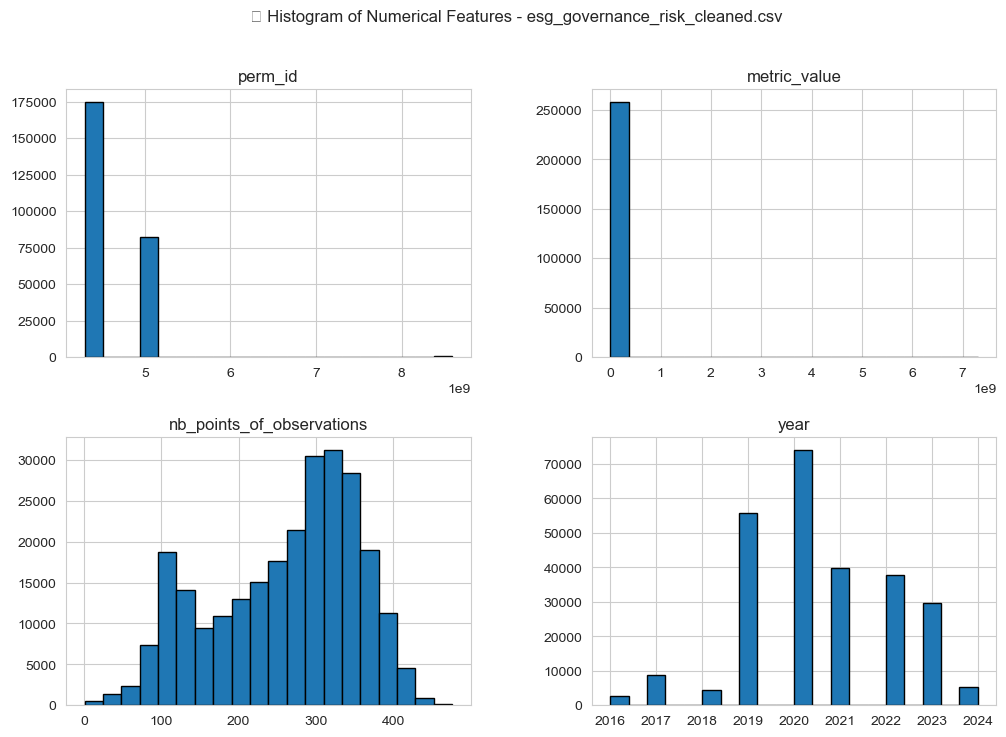


 Generating visualizations for: esg_governance_opportunity_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


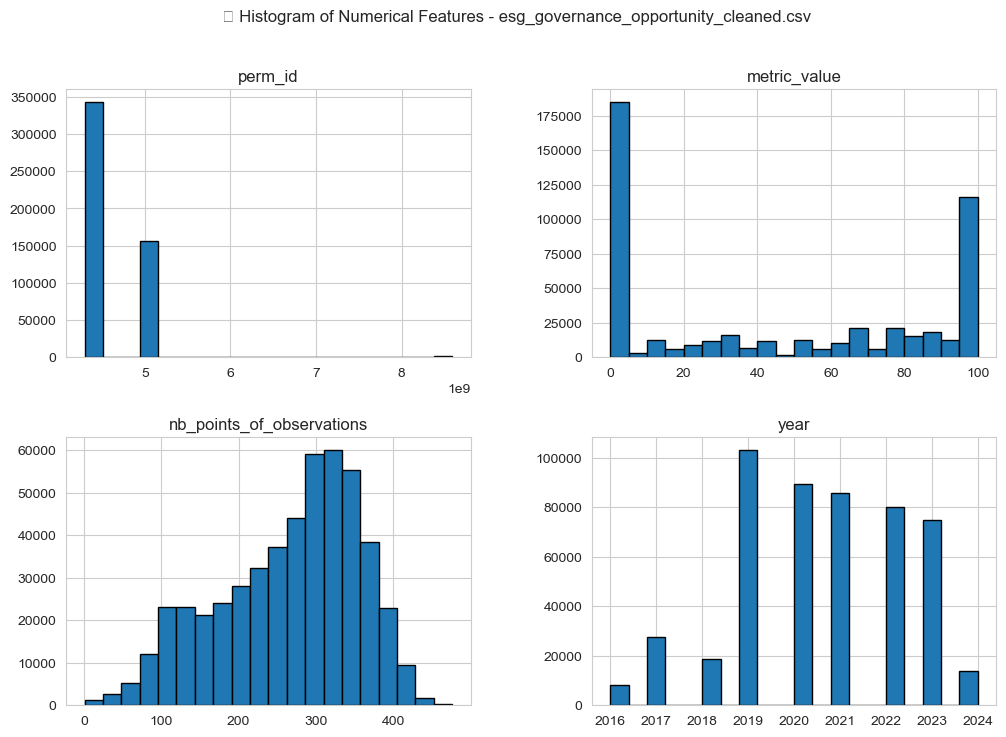


 Visualization process complete for all files!


In [7]:
# Loop through each file and generate visualizations
for filename in files_to_visualize:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    print(f"\n Generating visualizations for: {filename}")

    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(include=['number']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    # Histogram for numerical columns
    if len(num_cols) > 0:
        df[num_cols].hist(figsize=(12, 8), bins=20, edgecolor='black')
        plt.suptitle(f"📈 Histogram of Numerical Features - {filename}")
        plt.show()

print("\n Visualization process complete for all files!")


 Generating visualizations for: esg_environmental_risk_cleaned.csv


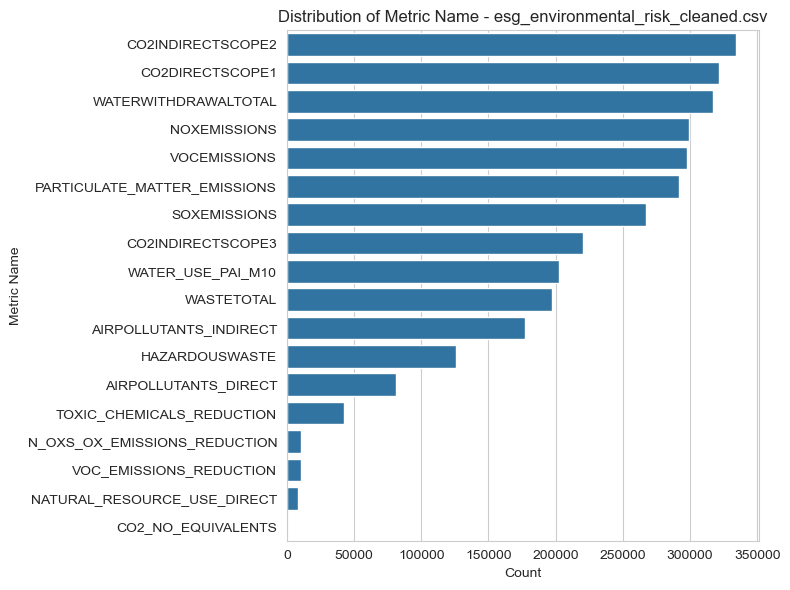


 Generating visualizations for: esg_environmental_opportunity_cleaned.csv


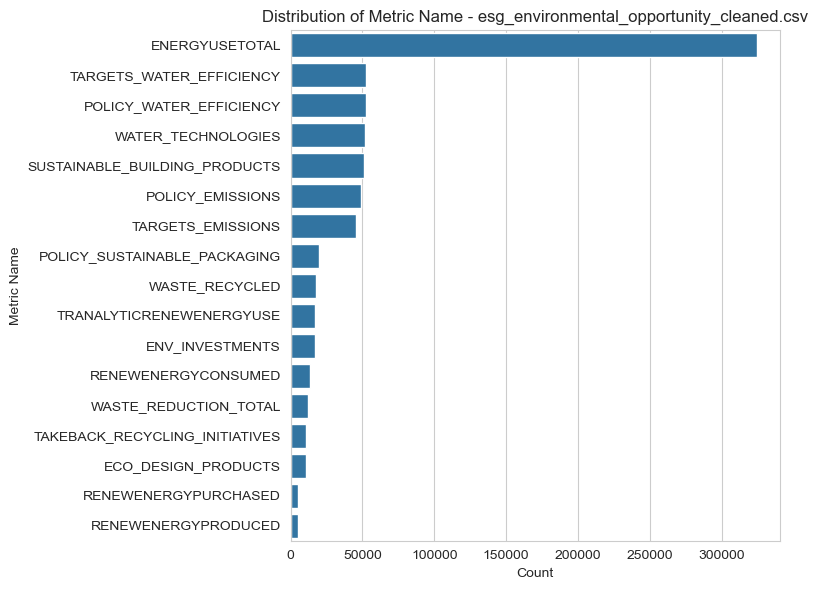


 Generating visualizations for: esg_social_risk_cleaned.csv


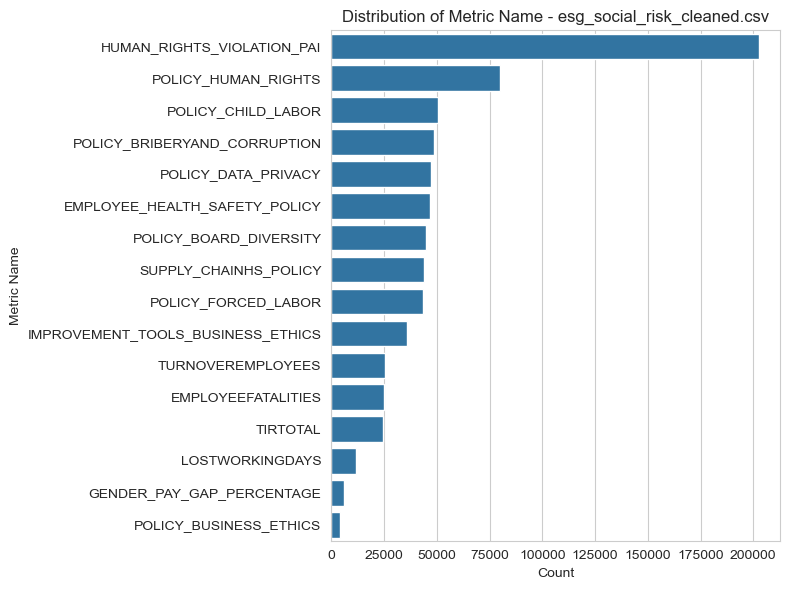


 Generating visualizations for: esg_social_opportunity_cleaned.csv


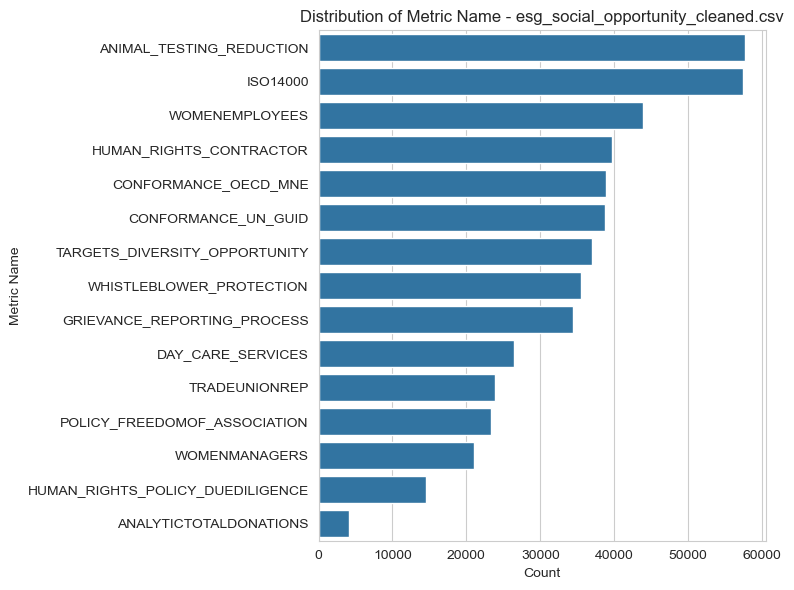


 Generating visualizations for: esg_governance_risk_cleaned.csv


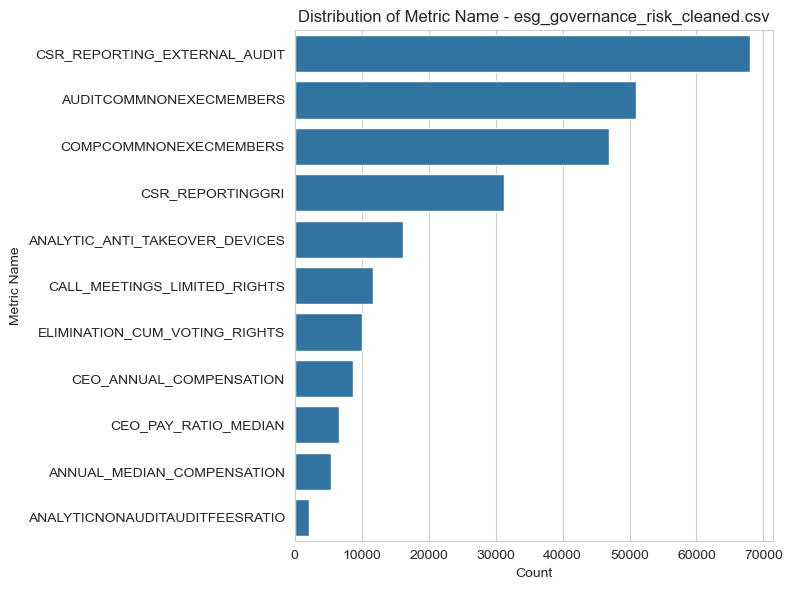


 Generating visualizations for: esg_governance_opportunity_cleaned.csv


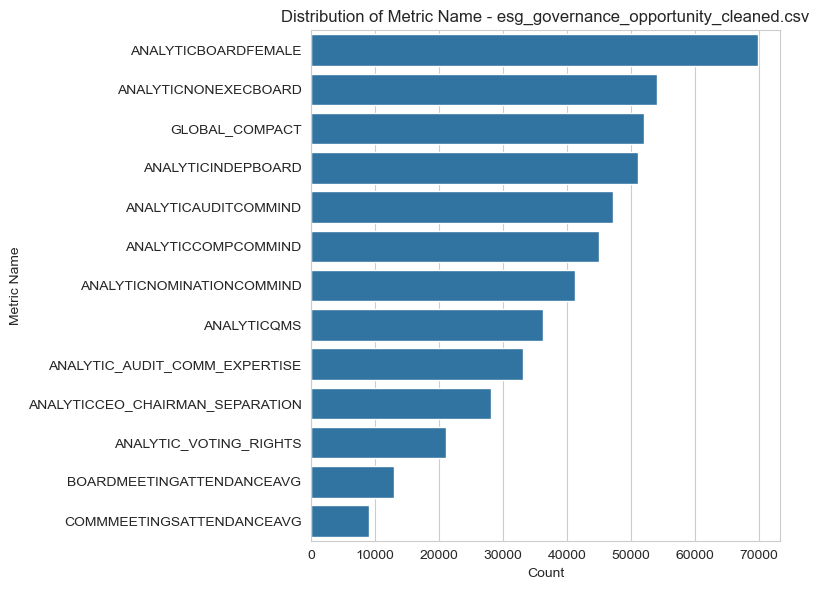


 Visualization process complete for all files!


In [8]:
	
target_column = "metric_name" 

# Loop through each file and generate visualizations
for filename in files_to_visualize:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    print(f"\n Generating visualizations for: {filename}")

    # Check if the target column exists
    if target_column in df.columns:
        plt.figure(figsize=(8, 6))

        # Display only the top 20 categories for better readability
        top_categories = df[target_column].value_counts().nlargest(20)

        sns.barplot(y=top_categories.index, x=top_categories.values, orient='h')

        plt.xlabel("Count")
        plt.ylabel(target_column.replace("_", " ").title())  # Format column name
        plt.title(f"Distribution of {target_column.replace('_', ' ').title()} - {filename}")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print(f"'{target_column}' column not found in {filename}")

print("\n Visualization process complete for all files!")


 Generating visualizations for: esg_environmental_risk_cleaned.csv


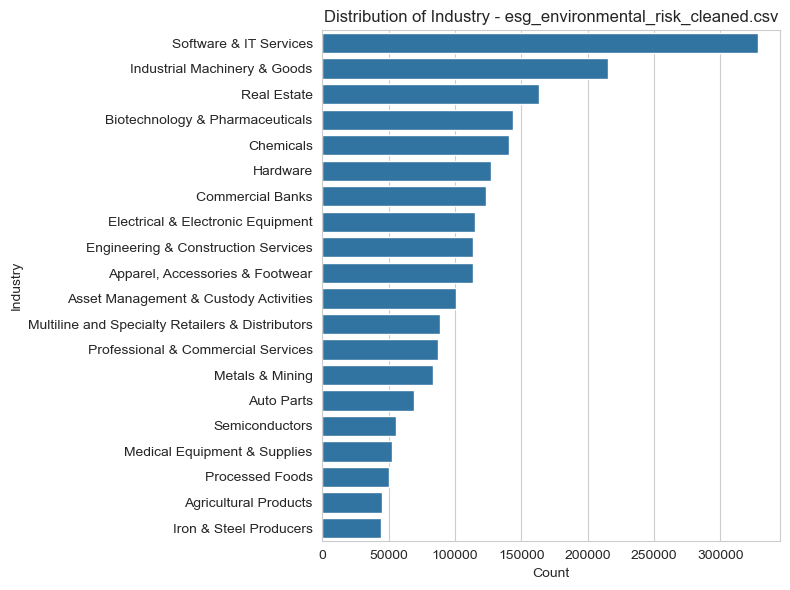


 Generating visualizations for: esg_environmental_opportunity_cleaned.csv


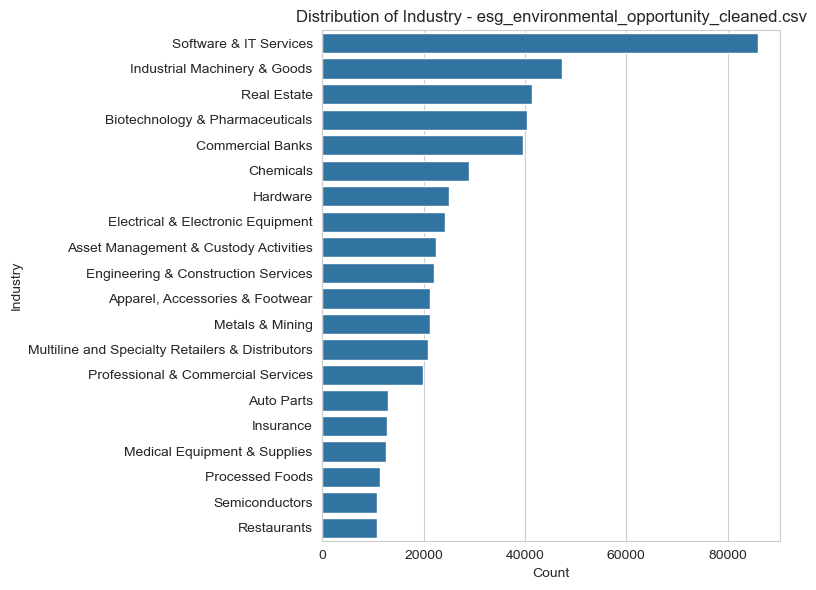


 Generating visualizations for: esg_social_risk_cleaned.csv


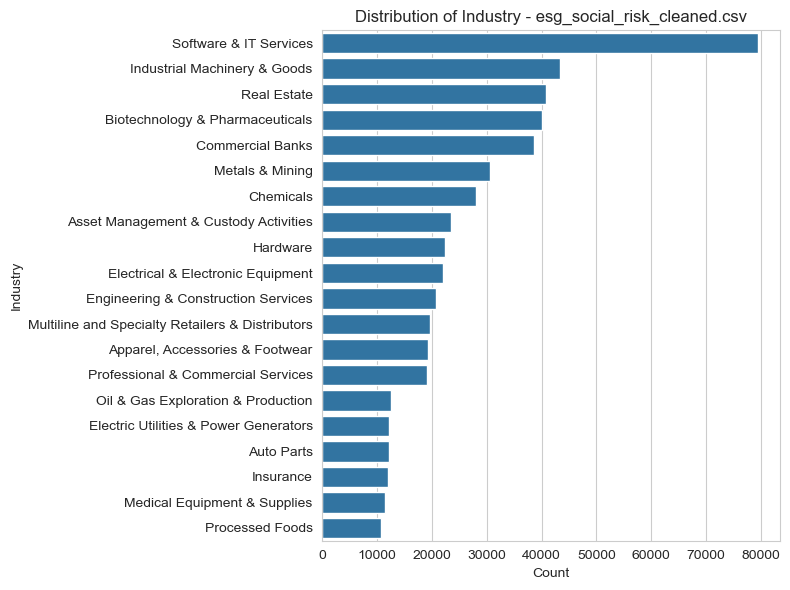


 Generating visualizations for: esg_social_opportunity_cleaned.csv


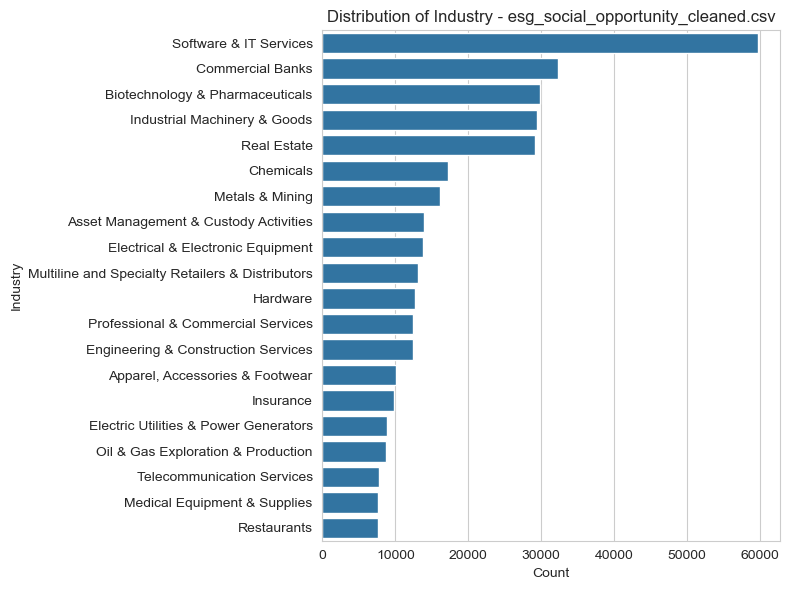


 Generating visualizations for: esg_governance_risk_cleaned.csv


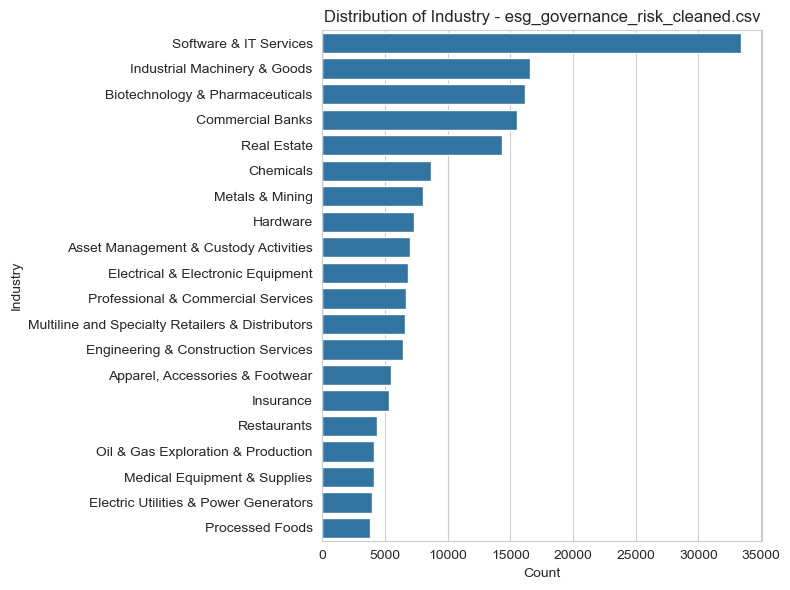


 Generating visualizations for: esg_governance_opportunity_cleaned.csv


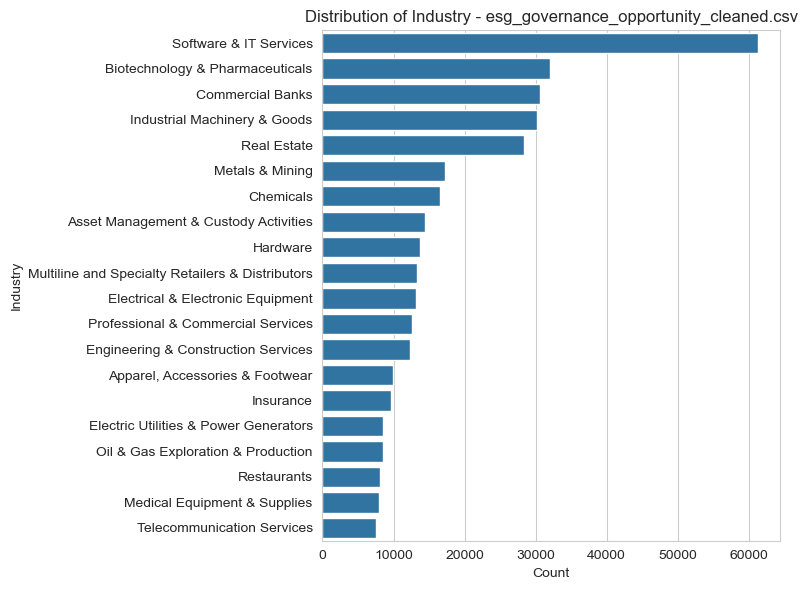


 Visualization process complete for all files!


In [9]:
target_column = "Industry" 

# Loop through each file and generate visualizations
for filename in files_to_visualize:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    print(f"\n Generating visualizations for: {filename}")

    # Check if the target column exists
    if target_column in df.columns:
        plt.figure(figsize=(8, 6))

        # Display only the top 20 categories for better readability
        top_categories = df[target_column].value_counts().nlargest(20)

        sns.barplot(y=top_categories.index, x=top_categories.values, orient='h')

        plt.xlabel("Count")
        plt.ylabel(target_column.replace("_", " ").title())  # Format column name
        plt.title(f"Distribution of {target_column.replace('_', ' ').title()} - {filename}")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print(f"'{target_column}' column not found in {filename}")

print("\n Visualization process complete for all files!")

In [2]:
# Define processed folder path
processed_folder_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed"

# Industries to focus on
selected_industries = ["Semiconductors", "Biotechnology & Pharmaceuticals"]

# Cleaned ESG files for processing
files_to_filter = [
    "esg_environmental_risk_cleaned.csv",
    "esg_environmental_opportunity_cleaned.csv",
    "esg_social_risk_cleaned.csv",
    "esg_social_opportunity_cleaned.csv",
    "esg_governance_risk_cleaned.csv",
    "esg_governance_opportunity_cleaned.csv"
]


In [60]:
def filter_by_industry(file_list, industries, save_path):
    """Filters the given ESG files for selected industries and saves them."""
    for filename in file_list:
        file_path = os.path.join(save_path, filename)

        # Load dataset
        df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

        # Filter dataset
        df_filtered = df[df["Industry"].isin(industries)]

        # Save filtered dataset
        new_filename = filename.replace(".csv", "_industry.csv")
        df_filtered.to_csv(os.path.join(save_path, new_filename), index=False, sep='|')

        print(f" Saved: {new_filename} with {df_filtered.shape[0]} rows")


In [63]:
filter_by_industry(files_to_filter, selected_industries, processed_folder_path)
print("\n Industry-specific ESG files have been successfully created!")


 Saved: esg_environmental_risk_cleaned_industry.csv with 199425 rows
 Saved: esg_environmental_opportunity_cleaned_industry.csv with 51207 rows
 Saved: esg_social_risk_cleaned_industry.csv with 50603 rows
 Saved: esg_social_opportunity_cleaned_industry.csv with 35987 rows
 Saved: esg_governance_risk_cleaned_industry.csv with 19569 rows
 Saved: esg_governance_opportunity_cleaned_industry.csv with 38592 rows

 Industry-specific ESG files have been successfully created!


In [64]:
# Industry-specific cleaned files
industry_files = [filename.replace(".csv", "_industry.csv") for filename in files_to_filter]

# Load data into a dictionary
industry_data = {
    filename: pd.read_csv(os.path.join(processed_folder_path, filename), delimiter='|', encoding='utf-8')
    for filename in industry_files
}
print("\nIndustry-specific data loaded successfully!")



Industry-specific data loaded successfully!


/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/635263008.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis",hue=None)


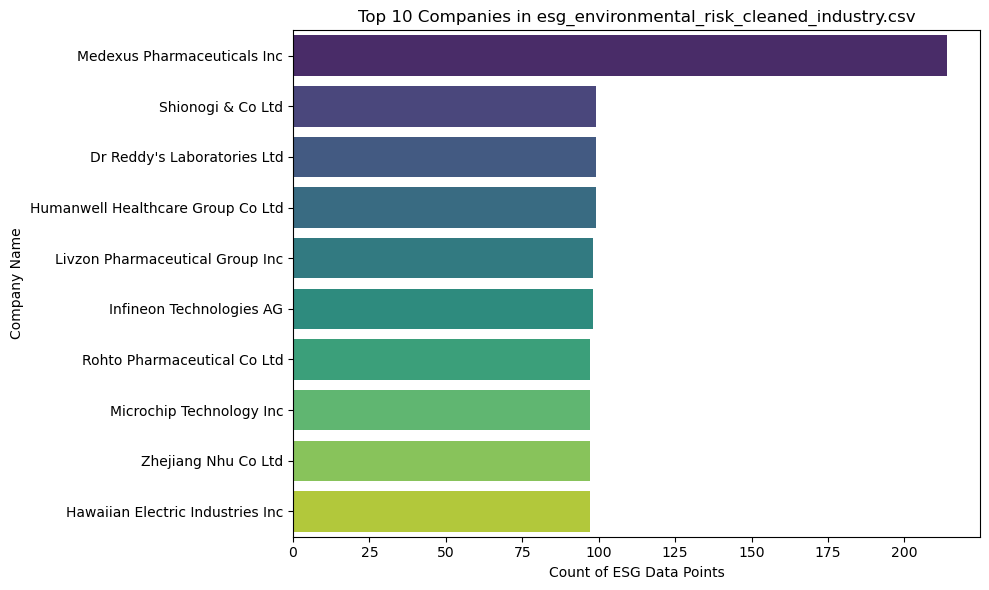

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/635263008.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis",hue=None)


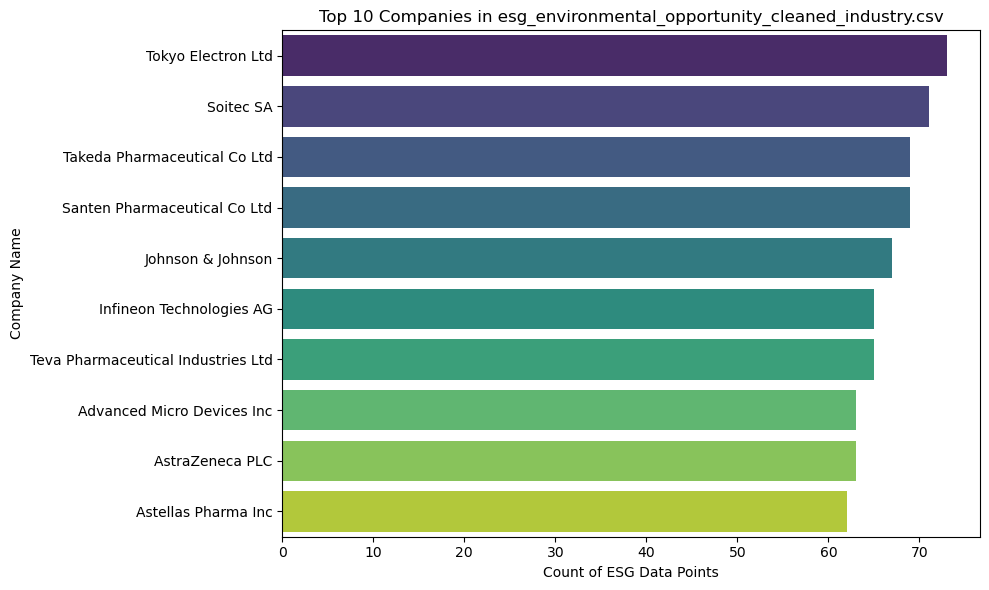

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/635263008.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis",hue=None)


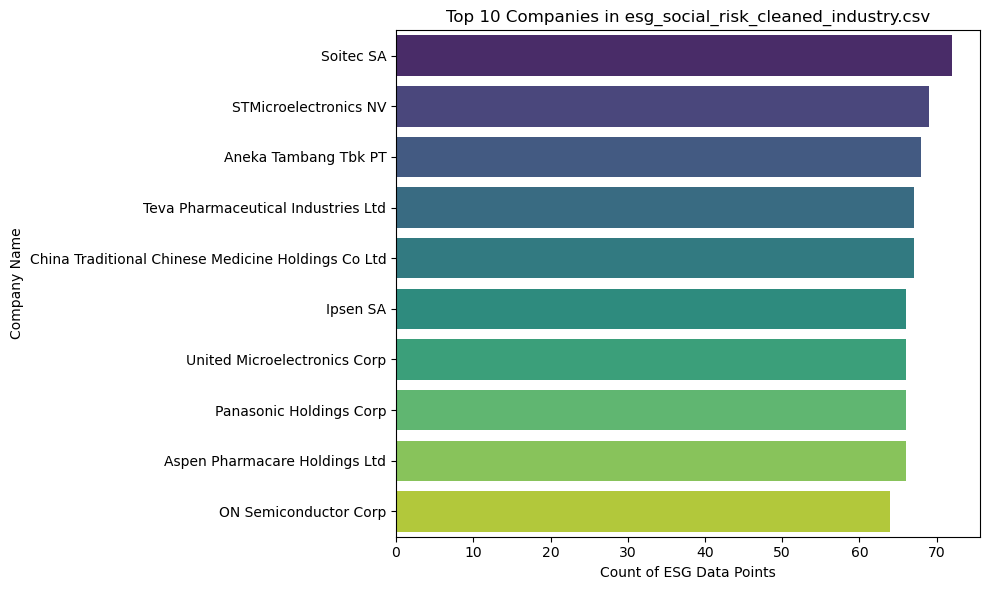

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/635263008.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis",hue=None)


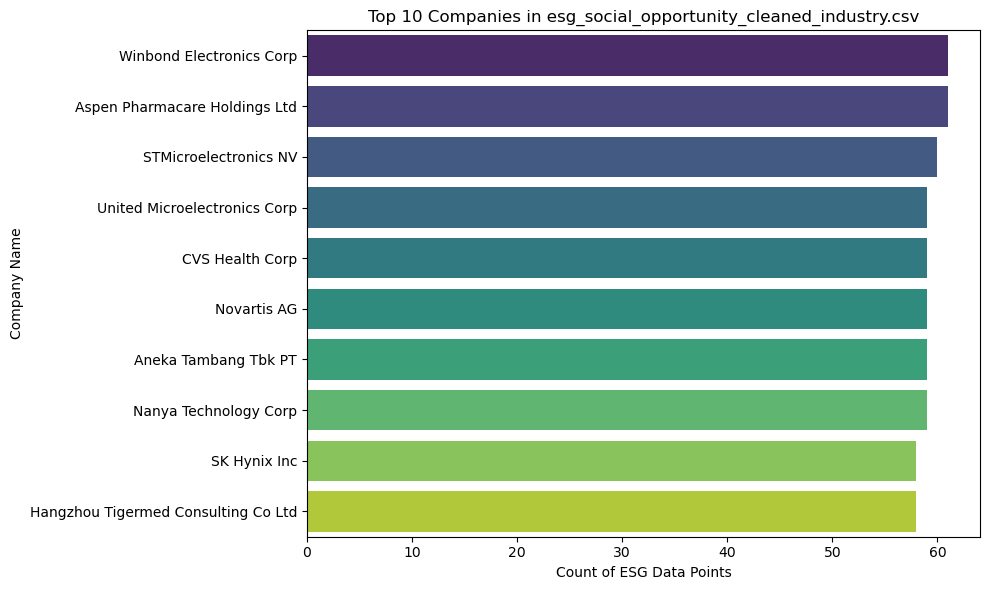

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/635263008.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis",hue=None)


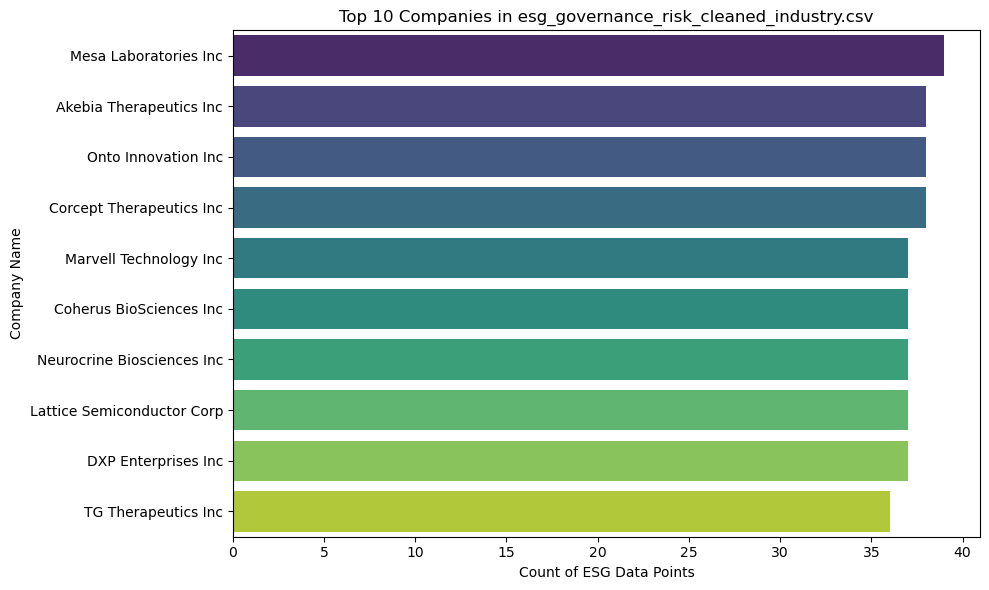

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/635263008.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis",hue=None)


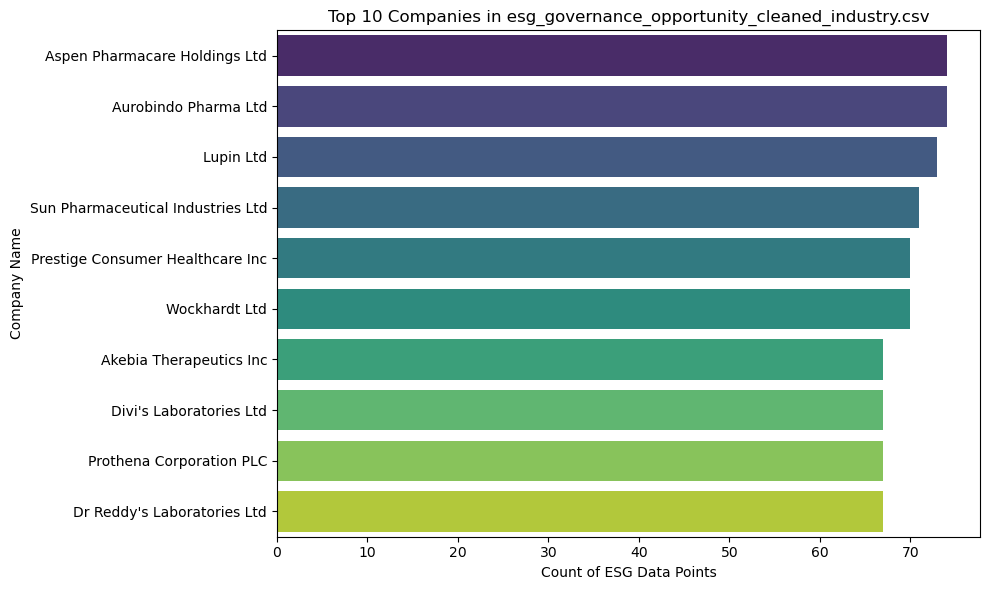

In [65]:
def plot_top_companies(data_dict):
    """Plots the top 10 companies reporting ESG metrics."""
    for filename, df in data_dict.items():
        top_companies = df["company_name"].value_counts().head(10)

        plt.figure(figsize=(10, 6))
        sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis",hue=None)
        plt.xlabel("Count of ESG Data Points")
        plt.ylabel("Company Name")
        plt.title(f"Top 10 Companies in {filename}")
        plt.tight_layout()
        plt.show()

plot_top_companies(industry_data)


In [5]:
def plot_esg_metrics(data, title_suffix):
    """Analyzes and visualizes ESG metrics trends for Risk and Opportunity separately."""
    
    if data.empty:
        print(f" No data available for {title_suffix}.")
        return

    # Step 1: Distribution of ESG Metrics per Company
    if "company_name" in data.columns:
        top_companies = data["company_name"].value_counts().head(10)
        plt.figure(figsize=(12, 6))
        sns.barplot(y=top_companies.index, x=top_companies.values, hue=None, palette="viridis", legend=False)
        plt.xlabel("Number of ESG Reports", fontsize=12)
        plt.ylabel("Company Name", fontsize=12)
        plt.title(f"Top 10 Companies Reporting {title_suffix} Metrics", fontsize=14, fontweight="bold")
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis="x", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Step 2: Variability of ESG Metrics
    if "metric_name" in data.columns:
        top_metrics = data["metric_name"].value_counts().head(10)
        plt.figure(figsize=(12, 6))
        sns.barplot(y=top_metrics.index, x=top_metrics.values, hue=None, palette="coolwarm", legend=False)
        plt.xlabel("Count of ESG Reports", fontsize=12)
        plt.ylabel("Metric Name", fontsize=12)
        plt.title(f"Top 10 Reported {title_suffix} Metrics", fontsize=14, fontweight="bold")
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis="x", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Step 3: Outlier Analysis
    if "Industry" in data.columns and "metric_value" in data.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=data, x="Industry", y="metric_value", palette="coolwarm", showfliers=True)
        plt.xlabel("Industry", fontsize=12)
        plt.ylabel("Metric Value", fontsize=12)
        plt.title(f"Outlier Detection in {title_suffix} Metrics", fontsize=14, fontweight="bold")
        plt.xticks(rotation=30, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Step 4: Correlation Heatmap (Filtered for Readability)
    if "year" in data.columns and "metric_value" in data.columns:
        pivot_data = data.pivot_table(index="year", columns="metric_name", values="metric_value", aggfunc="mean")

        # Compute correlation, dropping NA values
        corr_data = pivot_data.corr().dropna(axis=0, how='all').dropna(axis=1, how='all')

        plt.figure(figsize=(14, 8))
        sns.heatmap(
            corr_data, cmap="coolwarm", annot=False, linewidths=0.5, center=0,
            cbar_kws={"shrink": 0.75}, vmin=-1, vmax=1
        )
        plt.title(f"Correlation Heatmap of {title_suffix} Metrics", fontsize=14, fontweight="bold")
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.grid(False)
        plt.tight_layout()
        plt.show()

In [10]:
# Define file paths
env_risk_file = "esg_environmental_risk_cleaned_industry.csv"
env_opportunity_file = "esg_environmental_opportunity_cleaned_industry.csv"
soc_risk_file = "esg_social_risk_cleaned_industry.csv"
soc_opportunity_file = "esg_social_opportunity_cleaned_industry.csv"
gov_risk_file = "esg_governance_risk_cleaned_industry.csv"
gov_opportunity_file = "esg_governance_opportunity_cleaned_industry.csv"

# Load data for each category
df_env_risk = pd.read_csv(os.path.join(processed_folder_path, env_risk_file), delimiter='|', encoding='utf-8')
df_env_opportunity = pd.read_csv(os.path.join(processed_folder_path, env_opportunity_file), delimiter='|', encoding='utf-8')
df_soc_risk = pd.read_csv(os.path.join(processed_folder_path, soc_risk_file), delimiter='|', encoding='utf-8')
df_soc_opportunity = pd.read_csv(os.path.join(processed_folder_path, soc_opportunity_file), delimiter='|', encoding='utf-8')
df_gov_risk = pd.read_csv(os.path.join(processed_folder_path, gov_risk_file), delimiter='|', encoding='utf-8')
df_gov_opportunity = pd.read_csv(os.path.join(processed_folder_path, gov_opportunity_file), delimiter='|', encoding='utf-8')

# Filter for selected industries
for df in [df_env_risk, df_env_opportunity, df_soc_risk, df_soc_opportunity, df_gov_risk, df_gov_opportunity]:
    df = df[df["Industry"].isin(selected_industries)]
    df["year"] = pd.to_numeric(df["year"], errors='coerce')
    df.dropna(subset=["metric_value"], inplace=True)
    df["metric_value"] = pd.to_numeric(df["metric_value"], errors='coerce')



In [ ]:
# Run analysis for all ESG categories
print("\nAnalyzing Environmental Risk Metrics...")
plot_esg_metrics(df_env_risk, "Environmental Risk")

print("\nAnalyzing Environmental Opportunity Metrics...")
plot_esg_metrics(df_env_opportunity, "Environmental Opportunity")

print("\nAnalyzing Social Risk Metrics...")
plot_esg_metrics(df_soc_risk, "Social Risk")

print("\nAnalyzing Social Opportunity Metrics...")
plot_esg_metrics(df_soc_opportunity, "Social Opportunity")

print("\nAnalyzing Governance Risk Metrics...")
plot_esg_metrics(df_gov_risk, "Governance Risk")

print("\nAnalyzing Governance Opportunity Metrics...")
plot_esg_metrics(df_gov_opportunity, "Governance Opportunity")

In [4]:
# Load cleaned ESG datasets for all metrics
files_to_process = {
    "Environmental Risk": "esg_environmental_risk_cleaned_industry.csv",
    "Environmental Opportunity": "esg_environmental_opportunity_cleaned_industry.csv",
    "Social Risk": "esg_social_risk_cleaned_industry.csv",
    "Social Opportunity": "esg_social_opportunity_cleaned_industry.csv",
    "Governance Risk": "esg_governance_risk_cleaned_industry.csv",
    "Governance Opportunity": "esg_governance_opportunity_cleaned_industry.csv"
}

# Set your processed data folder path
processed_folder_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed"

# Create output folder for normalized data
normalized_folder_path = os.path.join(processed_folder_path, "normalized")
os.makedirs(normalized_folder_path, exist_ok=True)

# Define function for outlier removal
def remove_outliers(df, column):
    """Removes outliers using Z-score and IQR method."""
    if column not in df.columns:
        return df  # Skip if column doesn't exist

    # Z-score method
    df["z_score"] = zscore(df[column], nan_policy="omit")
    df = df[(df["z_score"].abs() <= 3)]  # Remove outliers with |Z| > 3

    # IQR method
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    df.drop(columns=["z_score"], inplace=True, errors="ignore")
    return df

# Define function for normalization
def normalize_data(df, column):
    """Normalizes the data using Min-Max Scaling and Log Transformation."""
    if column not in df.columns:
        return df  # Skip if column doesn't exist

    # Min-Max Scaling
    df["metric_value_scaled"] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

    # Log Transformation (only for non-zero values)
    df["metric_value_log"] = np.log1p(df[column])

    return df

# Process each ESG dataset
for category, filename in files_to_process.items():
    file_path = os.path.join(processed_folder_path, filename)
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    print(f" Processing {category} Data...")

    # Filter numeric values
    df["metric_value"] = pd.to_numeric(df["metric_value"], errors='coerce')
    df.dropna(subset=["metric_value"], inplace=True)

    # Apply outlier removal
    df_cleaned = remove_outliers(df, "metric_value")

    # Apply normalization
    df_normalized = normalize_data(df_cleaned, "metric_value")

    # Save cleaned and normalized data
    output_file = os.path.join(normalized_folder_path, filename.replace(".csv", "_normalized.csv"))
    df_normalized.to_csv(output_file, index=False, sep='|')

    print(f" Saved: {output_file} ({len(df_normalized)} rows)")

print("\n Step 1 Completed: Outliers removed & data normalized! ")

 Processing Environmental Risk Data...
 Saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/normalized/esg_environmental_risk_cleaned_industry_normalized.csv (159083 rows)
 Processing Environmental Opportunity Data...
 Saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/normalized/esg_environmental_opportunity_cleaned_industry_normalized.csv (41302 rows)
 Processing Social Risk Data...
 Saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/normalized/esg_social_risk_cleaned_industry_normalized.csv (48272 rows)
 Processing Social Opportunity Data...
 Saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/normalized/esg_social_opportunity_cleaned_industry_normalized.csv (32262 rows)
 Processing Governance Risk Data...
 Saved:


📊 Analyzing Trends for Environmental Risk...


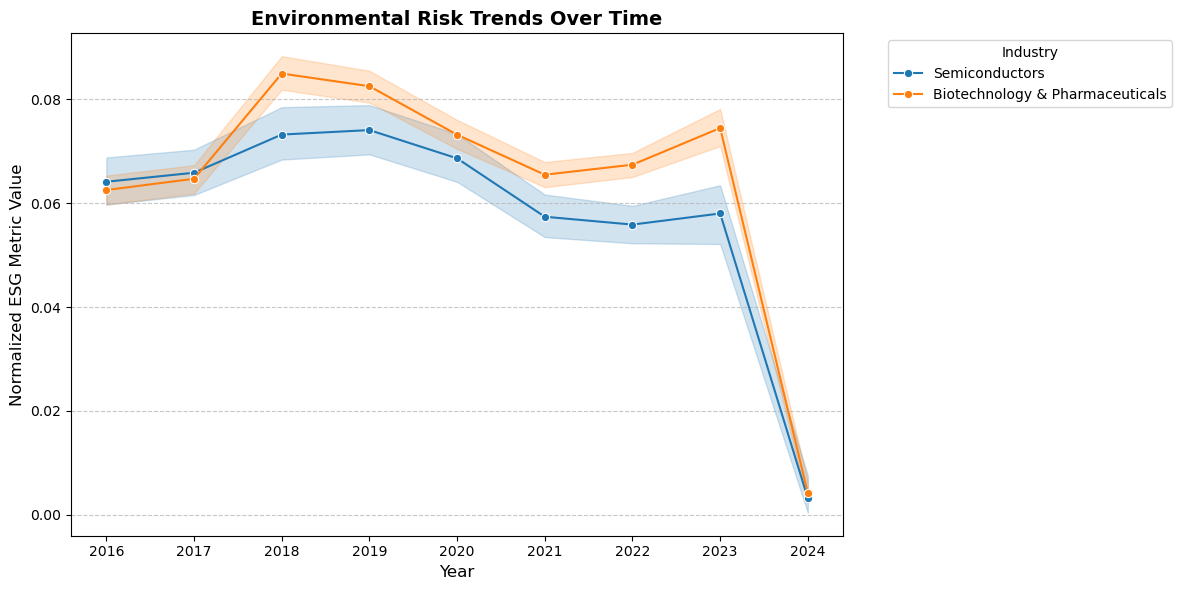


📊 Analyzing Trends for Environmental Opportunity...


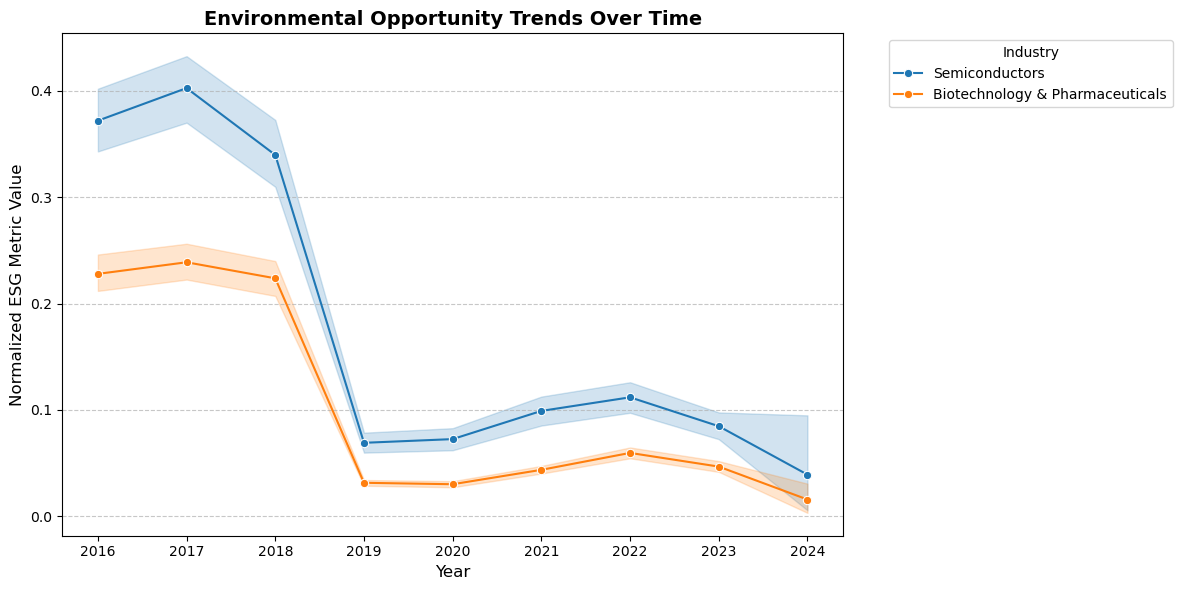


📊 Analyzing Trends for Social Risk...


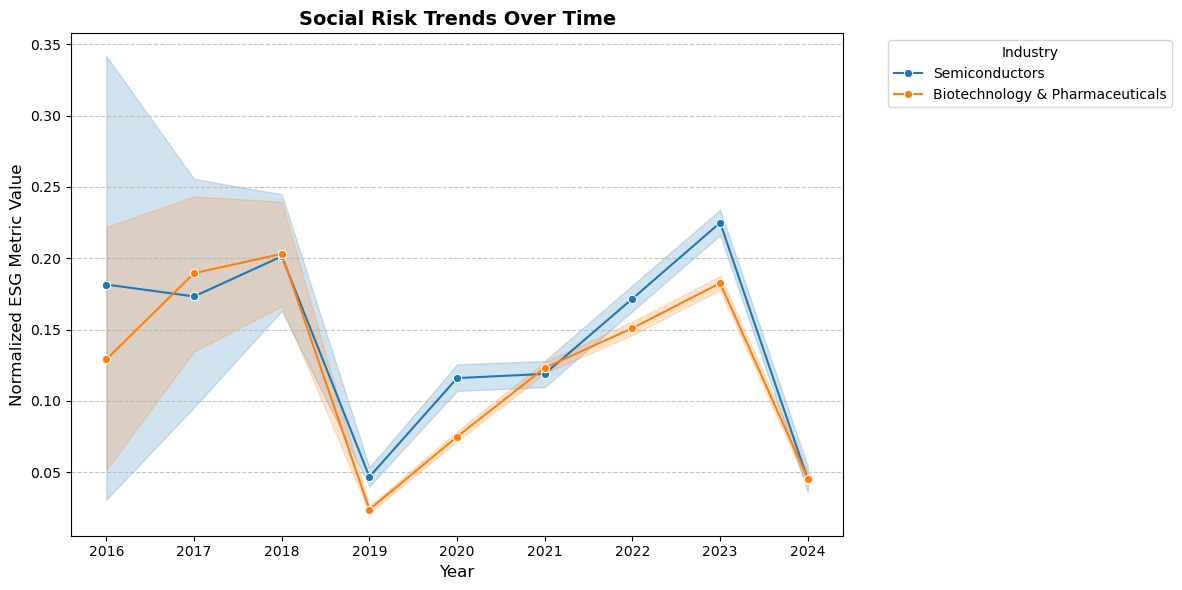


📊 Analyzing Trends for Social Opportunity...


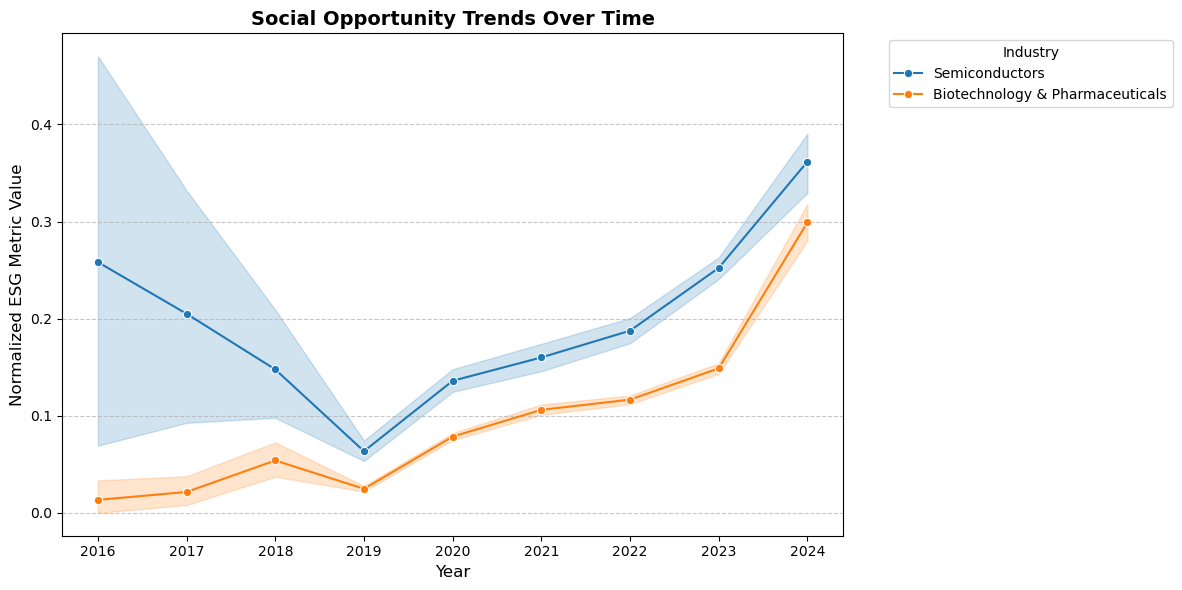


📊 Analyzing Trends for Governance Risk...


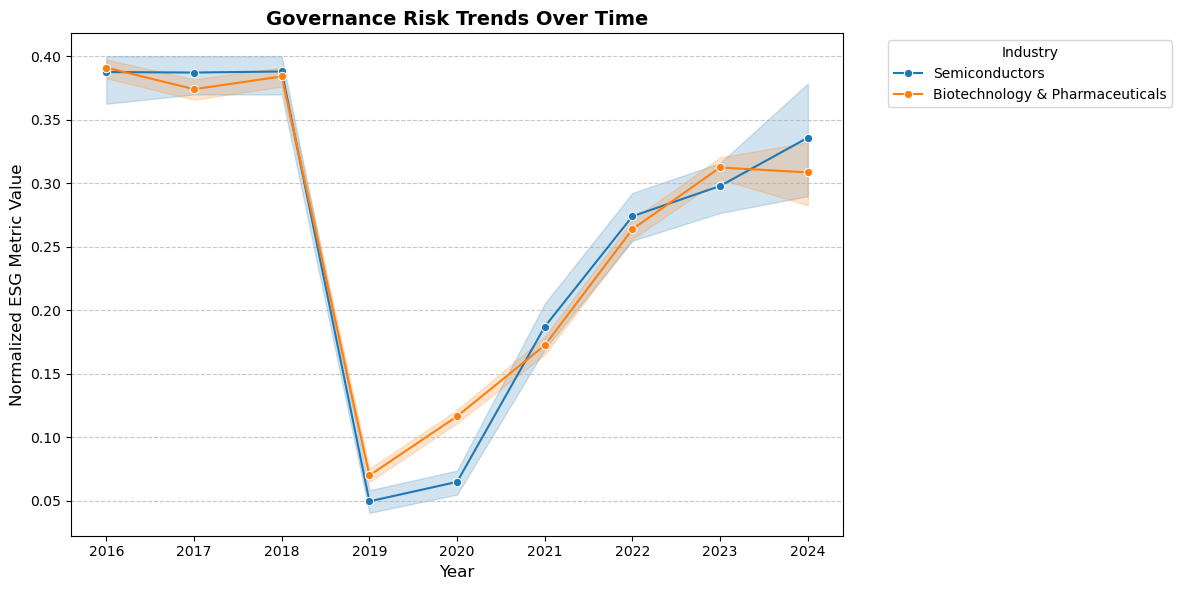


📊 Analyzing Trends for Governance Opportunity...


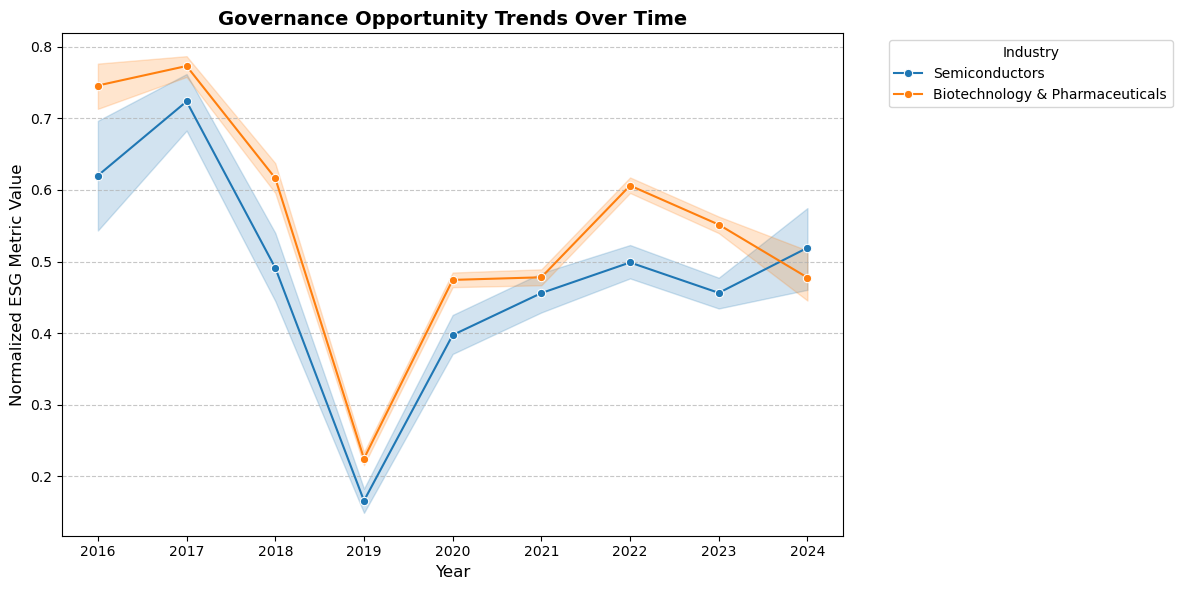


 Step 2 Completed: Time Series Analysis Done! 


In [6]:
# Set up paths
normalized_folder_path = os.path.join(processed_folder_path, "normalized")

# ESG categories and corresponding files
files_to_analyze = {
    "Environmental Risk": "esg_environmental_risk_cleaned_industry_normalized.csv",
    "Environmental Opportunity": "esg_environmental_opportunity_cleaned_industry_normalized.csv",
    "Social Risk": "esg_social_risk_cleaned_industry_normalized.csv",
    "Social Opportunity": "esg_social_opportunity_cleaned_industry_normalized.csv",
    "Governance Risk": "esg_governance_risk_cleaned_industry_normalized.csv",
    "Governance Opportunity": "esg_governance_opportunity_cleaned_industry_normalized.csv"
}

# Function to plot time series trends
def plot_time_series_trends(df, category):
    """Plots ESG metric trends over time for different industries."""
    if df.empty or "year" not in df.columns or "metric_value_scaled" not in df.columns:
        print(f" No valid data for {category}")
        return

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="year", y="metric_value_scaled", hue="Industry", marker="o", palette="tab10")

    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Normalized ESG Metric Value", fontsize=12)
    plt.title(f"{category} Trends Over Time", fontsize=14, fontweight="bold")
    plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Analyze trends for each ESG category
for category, filename in files_to_analyze.items():
    file_path = os.path.join(normalized_folder_path, filename)

    # Load data
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    # Convert year column to numeric
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df.dropna(subset=["year", "metric_value_scaled"], inplace=True)

    # Plot time series trends
    print(f"\n📊 Analyzing Trends for {category}...")
    plot_time_series_trends(df, category)

print("\n Step 2 Completed: Time Series Analysis Done! ")


 Analyzing Industry-Wise Distribution for Environmental Risk...


/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_2339/2022637230.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Industry", y="metric_value_scaled", palette="coolwarm", showfliers=False)


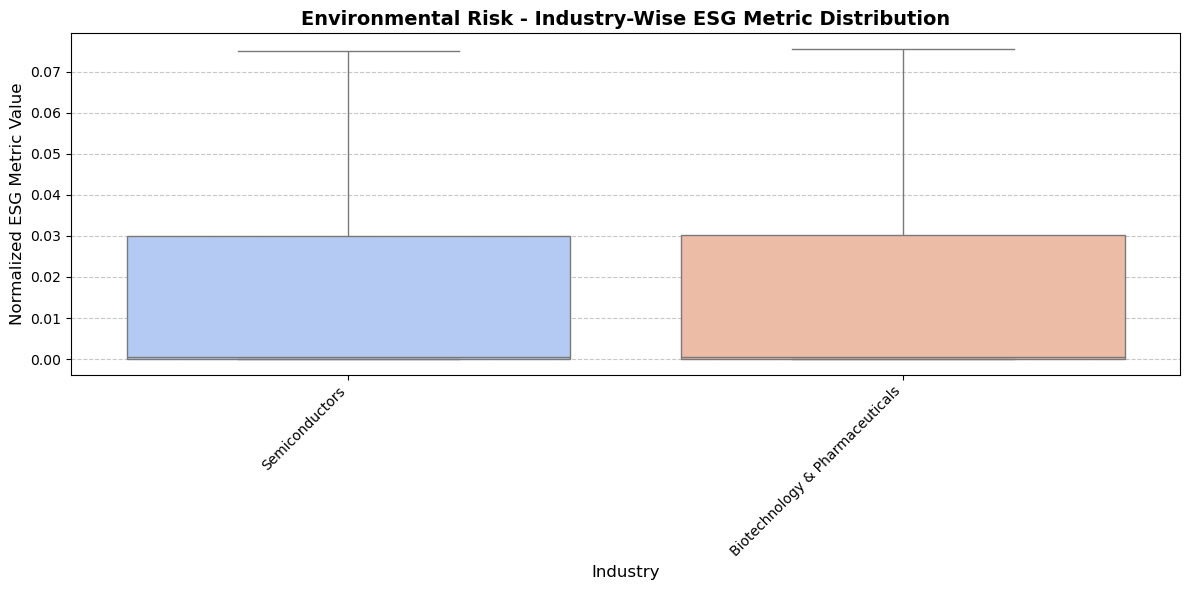


 Analyzing Industry-Wise Distribution for Environmental Opportunity...


/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_2339/2022637230.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Industry", y="metric_value_scaled", palette="coolwarm", showfliers=False)


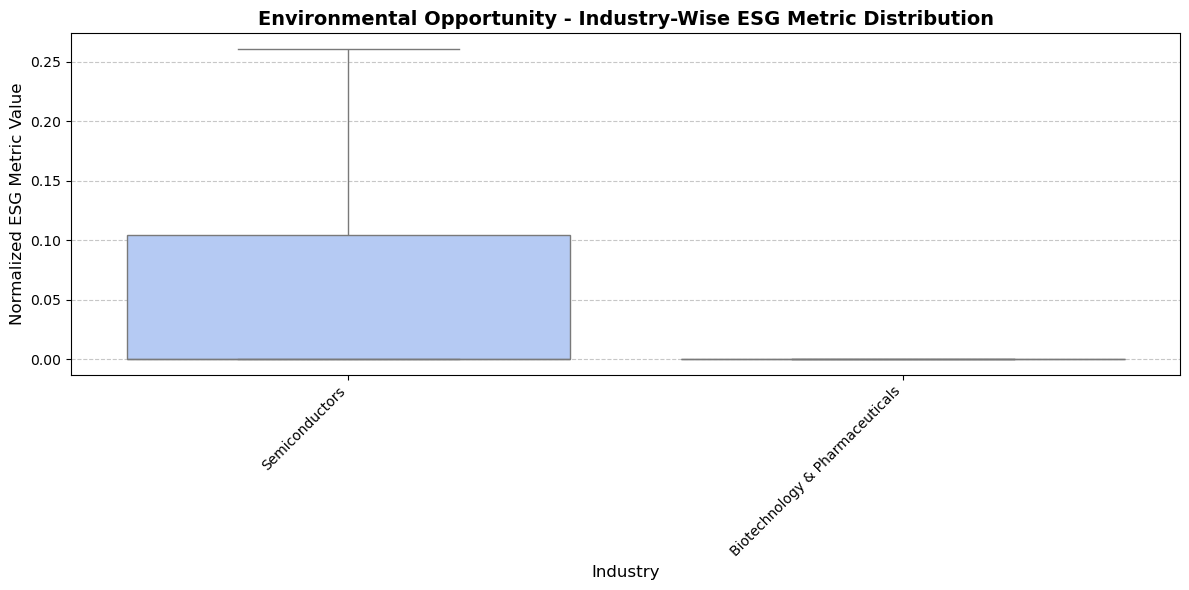


 Analyzing Industry-Wise Distribution for Social Risk...


/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_2339/2022637230.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Industry", y="metric_value_scaled", palette="coolwarm", showfliers=False)


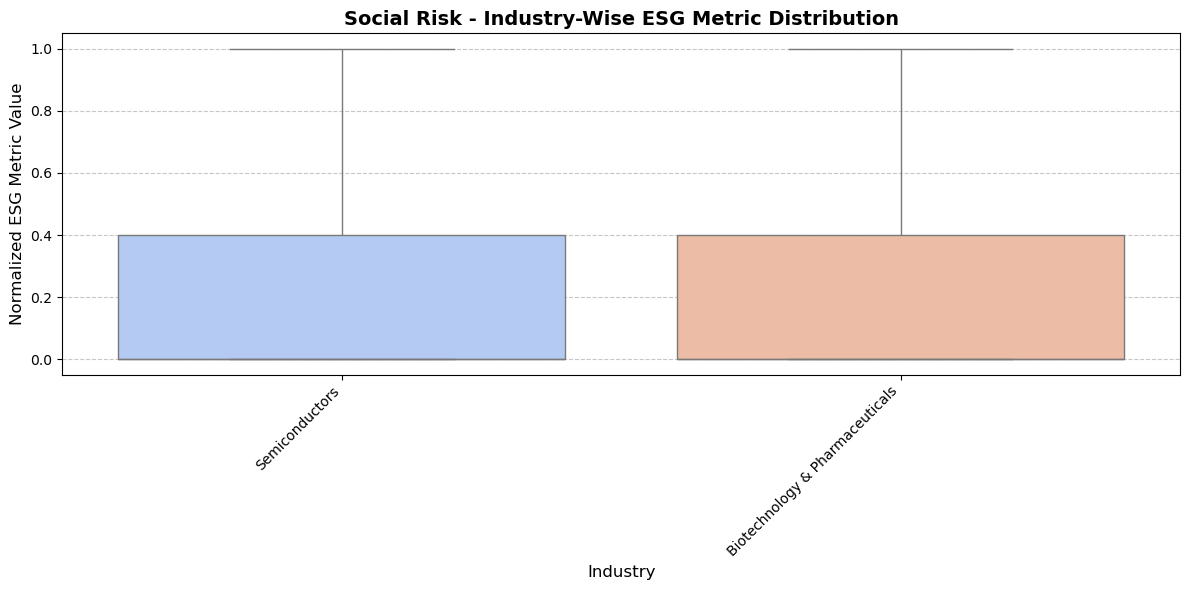


 Analyzing Industry-Wise Distribution for Social Opportunity...


/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_2339/2022637230.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Industry", y="metric_value_scaled", palette="coolwarm", showfliers=False)


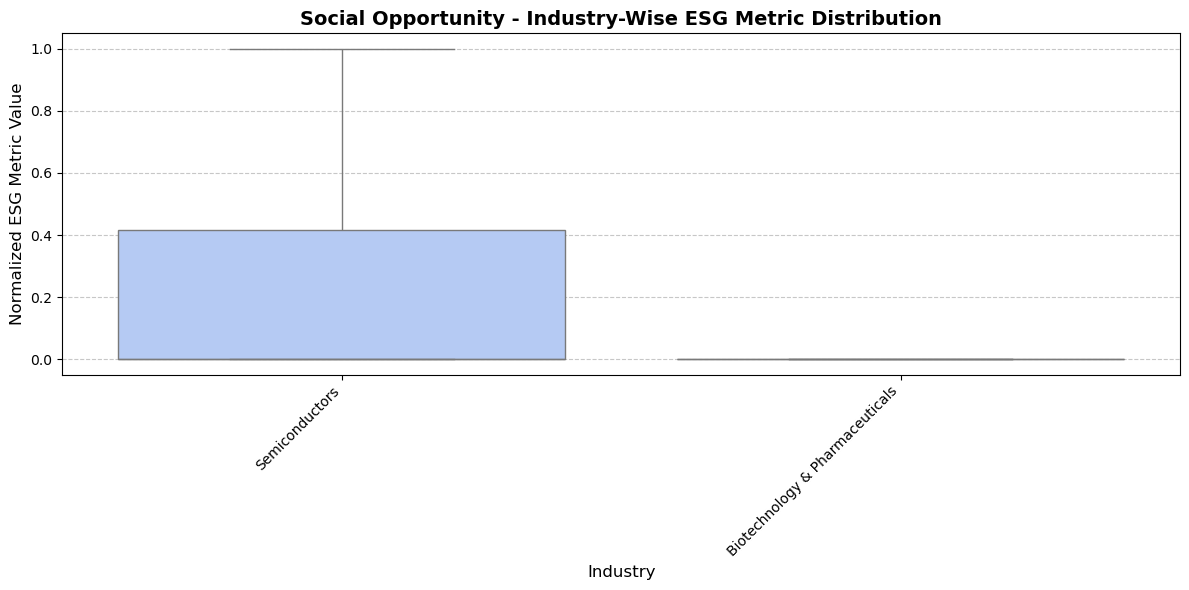


 Analyzing Industry-Wise Distribution for Governance Risk...


/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_2339/2022637230.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Industry", y="metric_value_scaled", palette="coolwarm", showfliers=False)


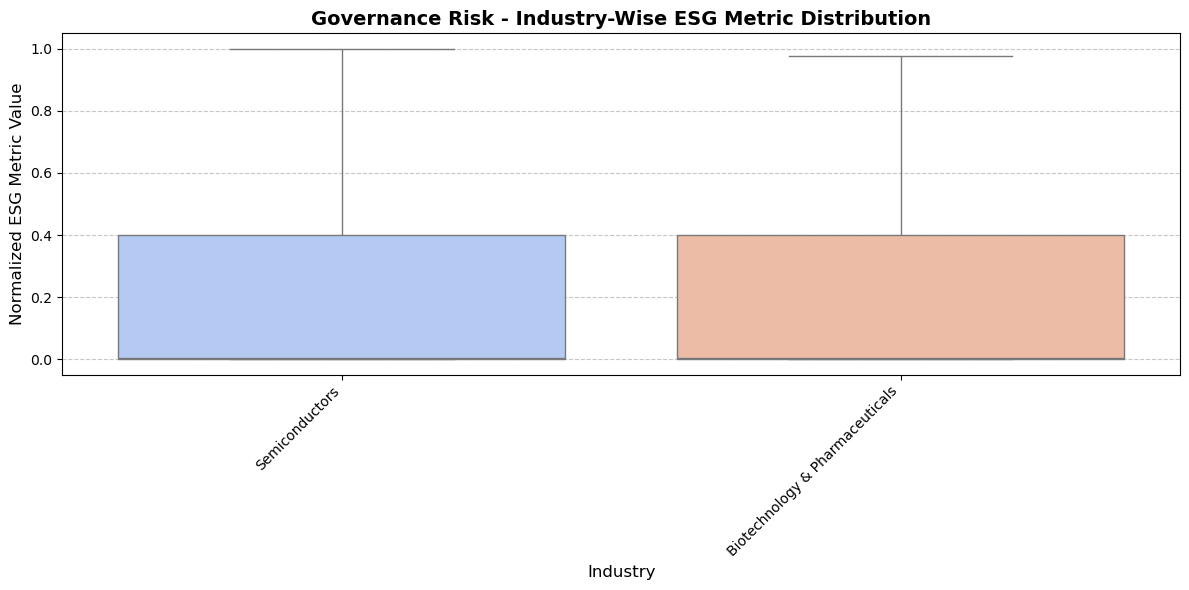


 Analyzing Industry-Wise Distribution for Governance Opportunity...


/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_2339/2022637230.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Industry", y="metric_value_scaled", palette="coolwarm", showfliers=False)


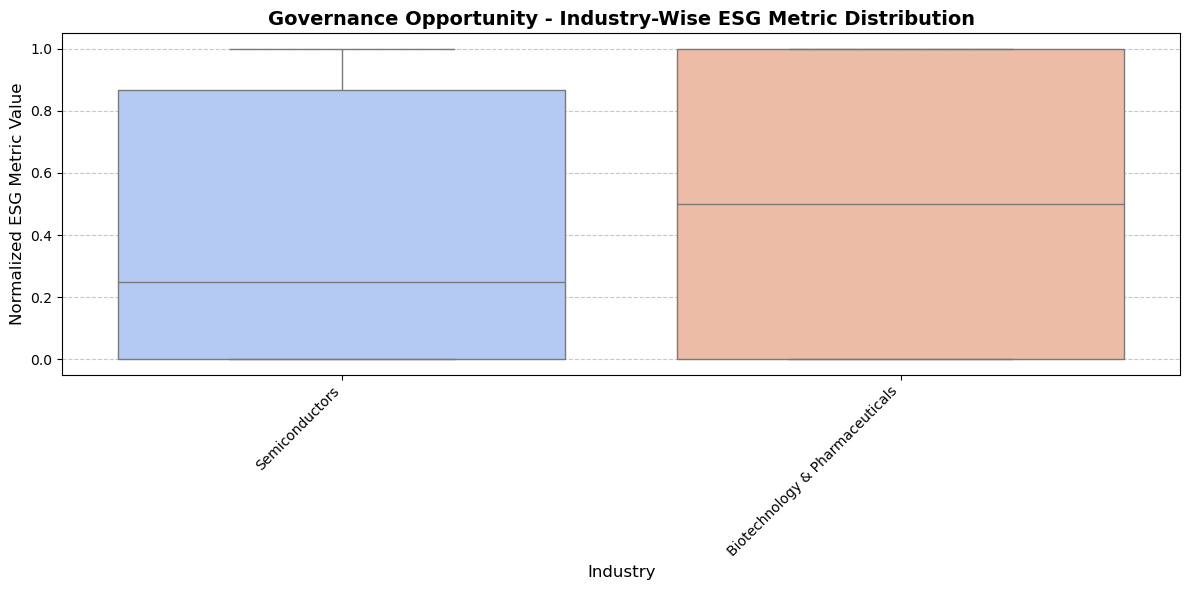


 Step 3 Completed: Industry-Wise ESG Metric Comparison Done!


In [13]:
# Function to compare ESG metric distributions across industries
def plot_industry_distribution(df, category):
    """Plots boxplot distribution of normalized ESG metrics per industry."""
    if df.empty or "Industry" not in df.columns or "metric_value_scaled" not in df.columns:
        print(f" No valid data for {category}")
        return

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="Industry", y="metric_value_scaled", palette="coolwarm", showfliers=False)

    plt.xlabel("Industry", fontsize=12)
    plt.ylabel("Normalized ESG Metric Value", fontsize=12)
    plt.title(f"{category} - Industry-Wise ESG Metric Distribution", fontsize=14, fontweight="bold")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run industry-wise analysis for each ESG category
for category, filename in files_to_analyze.items():
    file_path = os.path.join(normalized_folder_path, filename)

    # Load data
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    # Drop missing values
    df.dropna(subset=["Industry", "metric_value_scaled"], inplace=True)

    # Plot industry-wise ESG metric distribution
    print(f"\n Analyzing Industry-Wise Distribution for {category}...")
    plot_industry_distribution(df, category)

print("\n Step 3 Completed: Industry-Wise ESG Metric Comparison Done!")



 Analyzing Correlation for Environmental Risk...


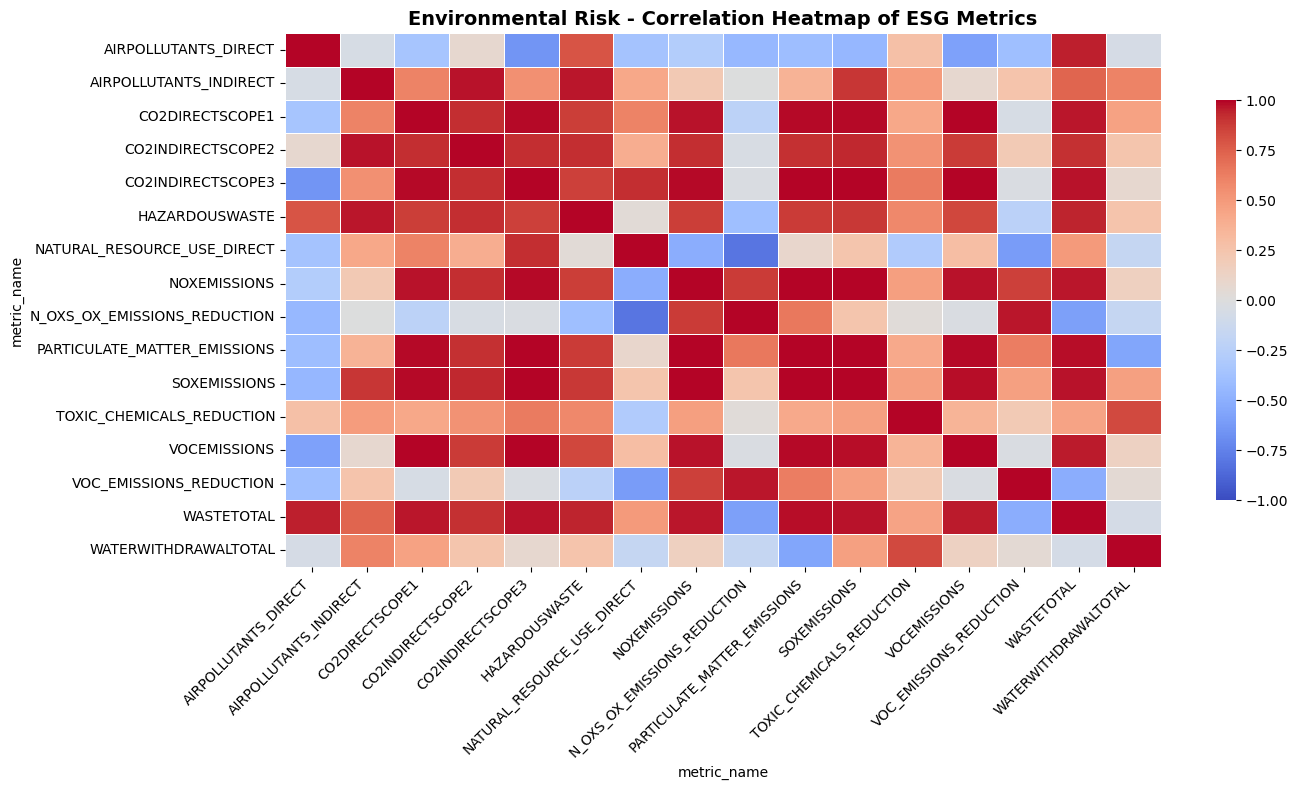


 Analyzing Correlation for Environmental Opportunity...


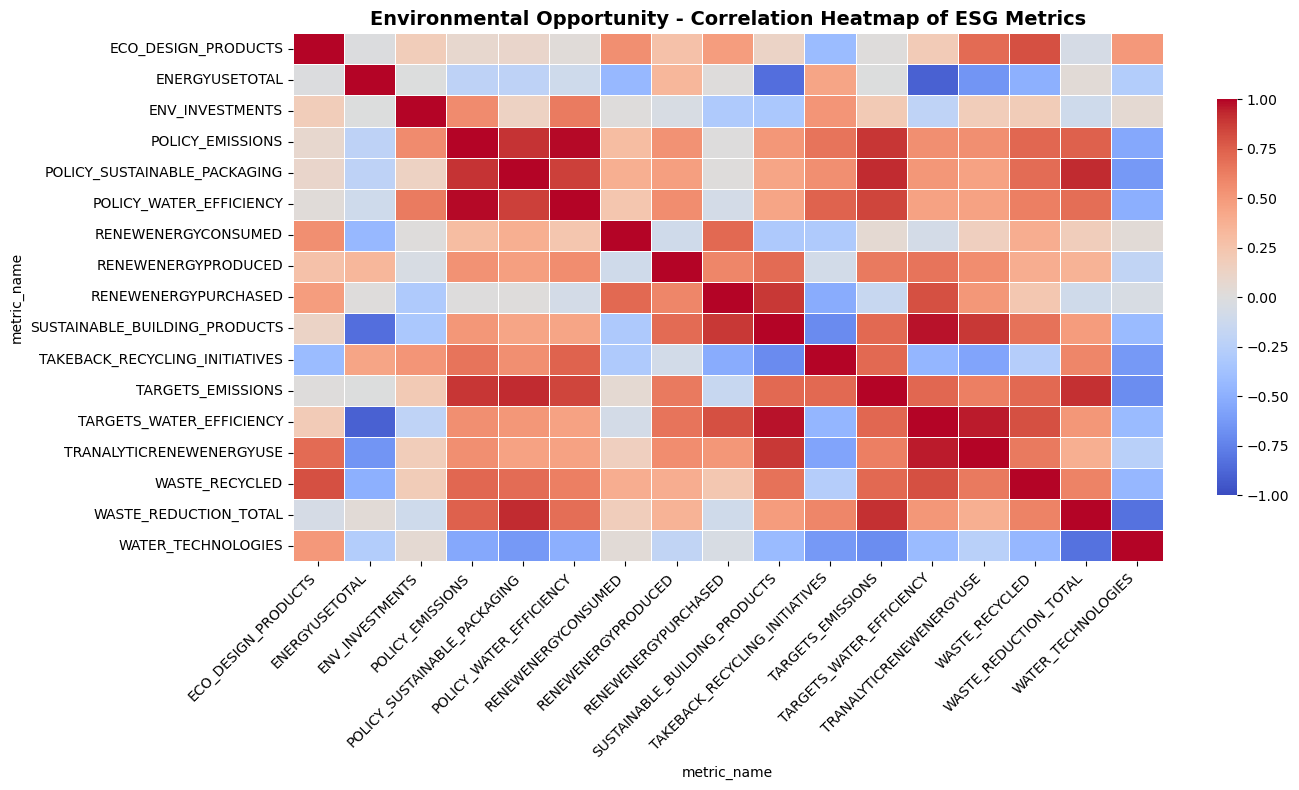


 Analyzing Correlation for Social Risk...


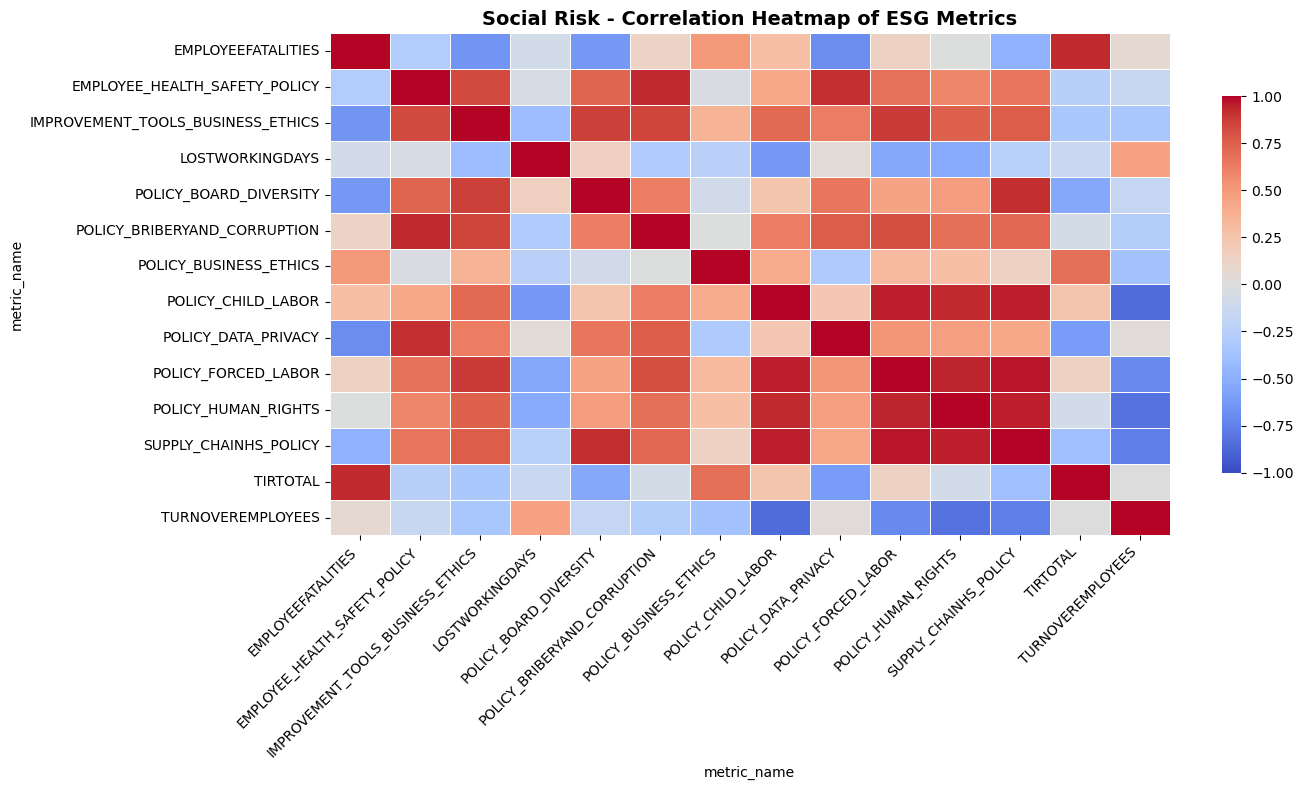


 Analyzing Correlation for Social Opportunity...


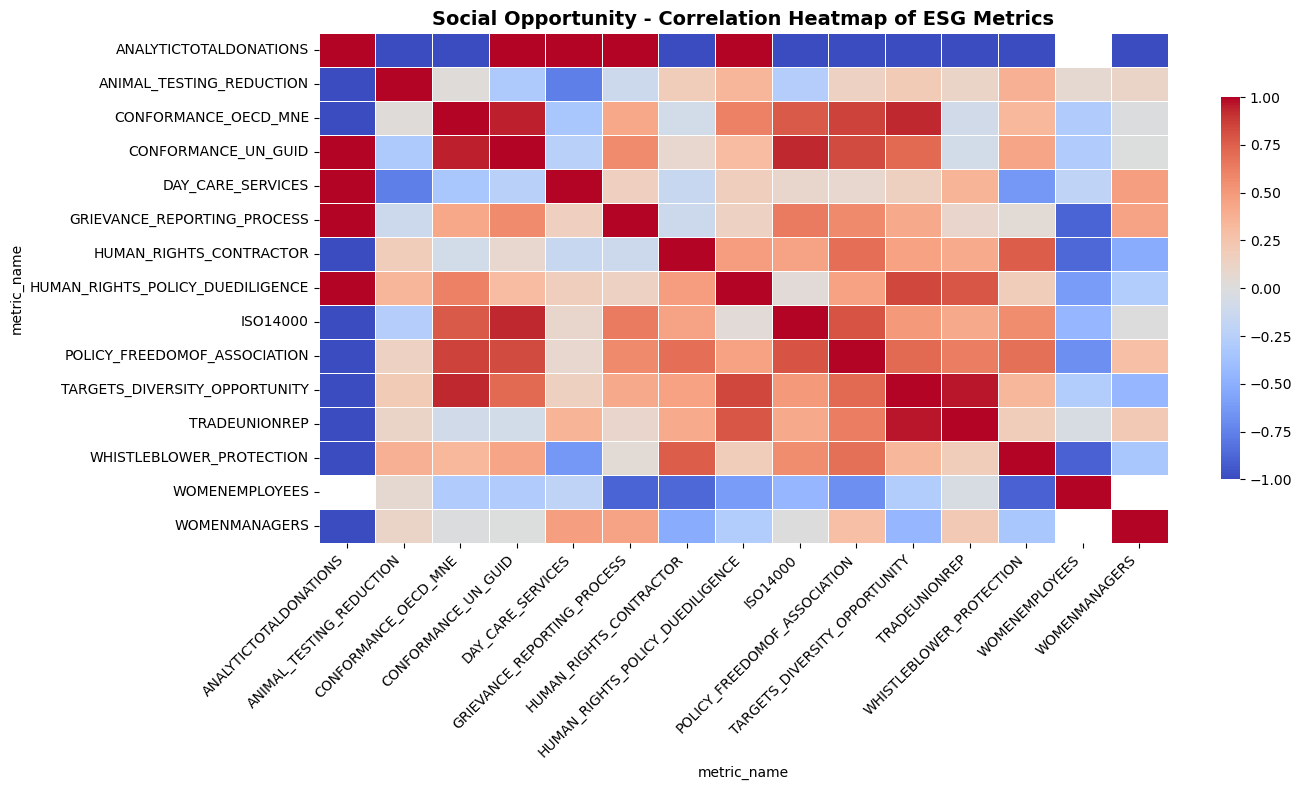


 Analyzing Correlation for Governance Risk...


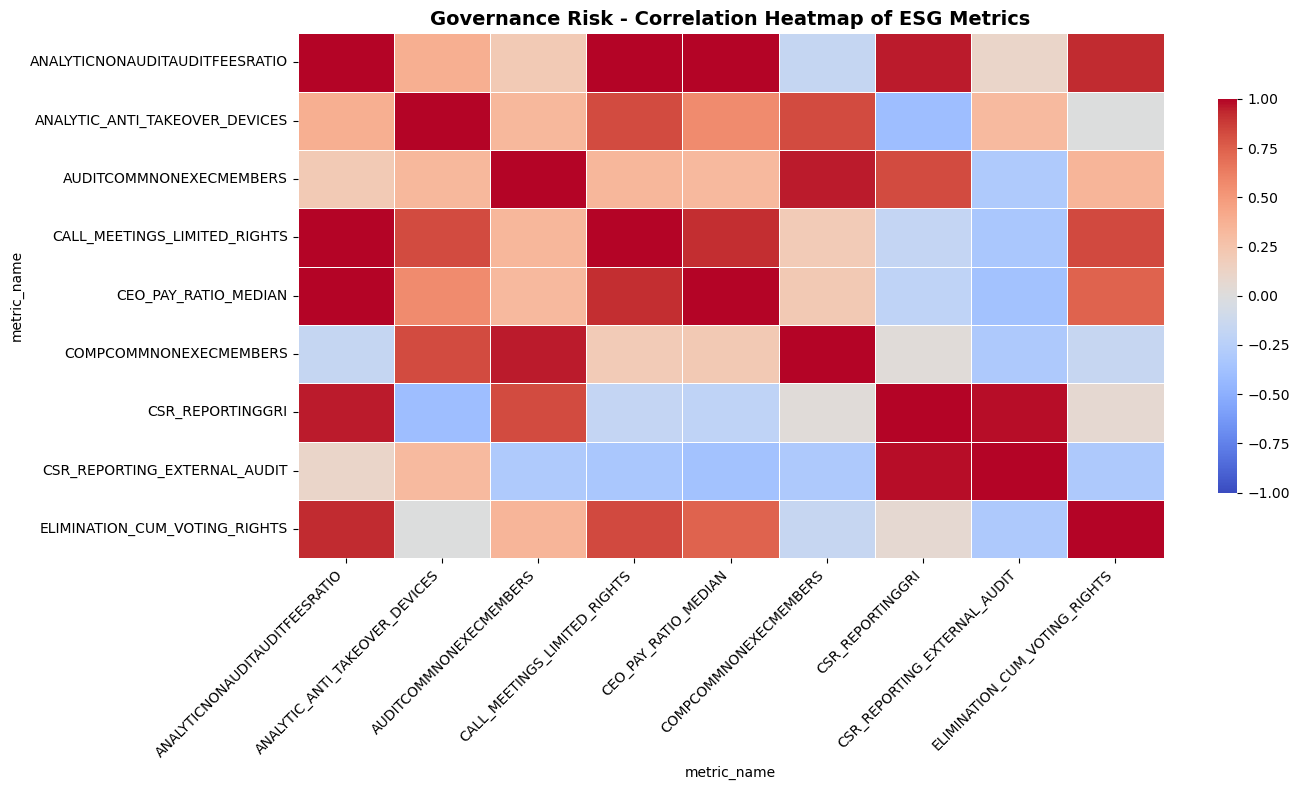


 Analyzing Correlation for Governance Opportunity...


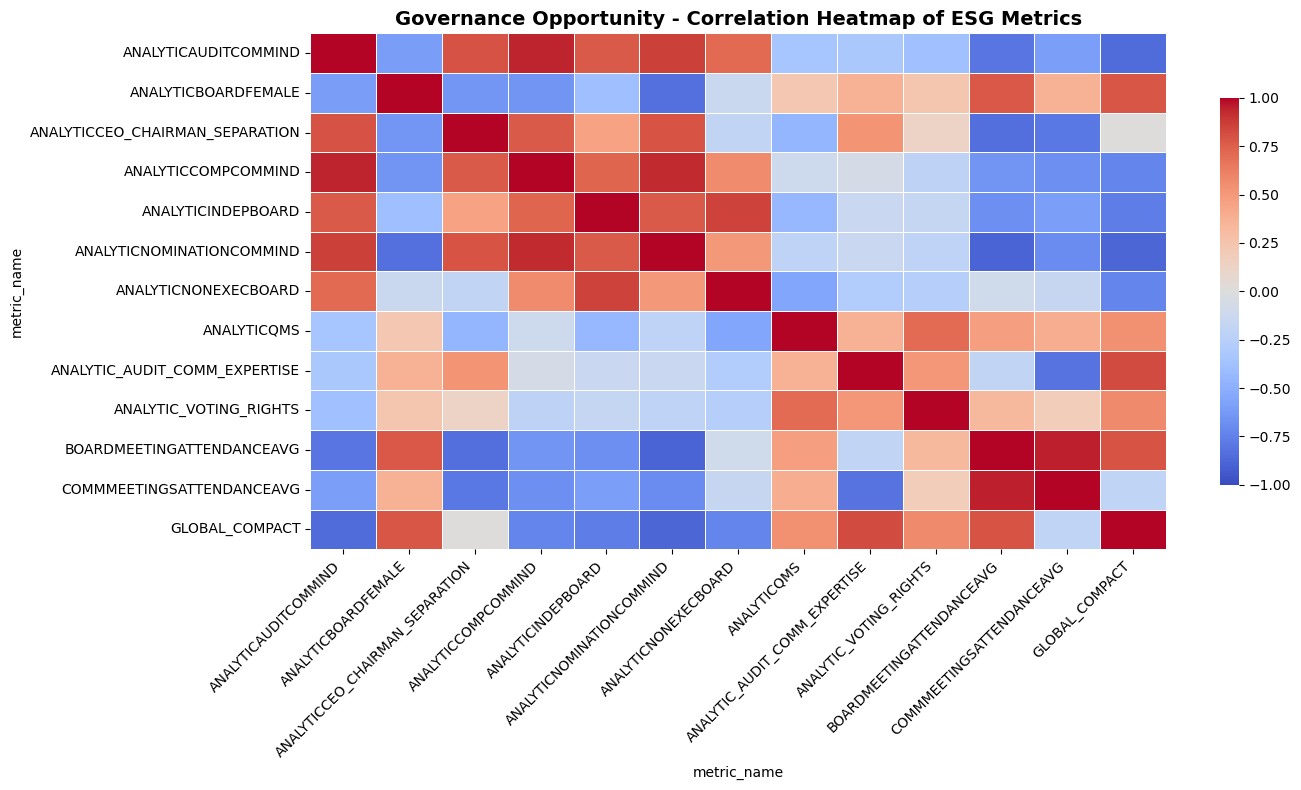


 Step 4 Completed: Correlation Analysis Done!


In [15]:
# Function to plot correlation heatmap of ESG metrics
def plot_correlation_heatmap(df, category):
    """Generates a heatmap of correlation between ESG metrics."""
    if df.empty or "metric_name" not in df.columns or "metric_value_scaled" not in df.columns:
        print(f" No valid data for {category}")
        return

    # Pivot data for correlation matrix
    pivot_df = df.pivot_table(index="year", columns="metric_name", values="metric_value_scaled", aggfunc="mean")

    # Compute correlation
    correlation_matrix = pivot_df.corr().dropna(axis=0, how='all').dropna(axis=1, how='all')

    # Plot heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5, center=0,
                cbar_kws={"shrink": 0.75}, vmin=-1, vmax=1)

    plt.title(f"{category} - Correlation Heatmap of ESG Metrics", fontsize=14, fontweight="bold")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Run correlation analysis for each ESG category
for category, filename in files_to_analyze.items():
    file_path = os.path.join(normalized_folder_path, filename)

    # Load data
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    # Drop missing values
    df.dropna(subset=["metric_name", "metric_value_scaled"], inplace=True)

    # Plot correlation heatmap
    print(f"\n Analyzing Correlation for {category}...")
    plot_correlation_heatmap(df, category)

print("\n Step 4 Completed: Correlation Analysis Done!")


In [6]:

csv_folder = "/Users/vinantipathare/Desktop/Docs/CS Project/capstone-project-2025-t1-25t1-9900-t12a-chocolate/Normalized_Data"  # Change this to the actual folder path

new_processed_path = "/Users/vinantipathare/Desktop/Docs/CS Project/Ontology_PCA_Project/Processed_dataset"

# Process each ESG CSV file
for file_name in os.listdir(csv_folder):
    if file_name.endswith(".csv"):
        file_path = os.path.join(csv_folder, file_name)

        # Load CSV file
        df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

        # Determine ESG Pillar (E, S, G) and Type (Risk/Opportunity) from filename
        if "environmental" in file_name.lower():
            pillar_type = "E"
        elif "social" in file_name.lower():
            pillar_type = "S"
        elif "governance" in file_name.lower():
            pillar_type = "G"
        else:
            continue  # Skip files that don’t match ESG categories

        risk_type = "risk" if "risk" in file_name.lower() else "opportunity"

        # Update the 'pillar' column with the new format
        df["pillar"] = f"{pillar_type}_{risk_type}"

        # Save the updated file
        output_file = os.path.join(new_processed_path, file_name.replace(".csv", "_updated_pillar.csv"))
        df.to_csv(output_file, index=False, sep='|')

        print(f"Updated file saved: {output_file}")

Updated file saved: /Users/vinantipathare/Desktop/Docs/CS Project/Ontology_PCA_Project/Processed_dataset/esg_social_risk_cleaned_industry_normalized_updated_pillar.csv
Updated file saved: /Users/vinantipathare/Desktop/Docs/CS Project/Ontology_PCA_Project/Processed_dataset/esg_social_opportunity_cleaned_industry_normalized_updated_pillar.csv
Updated file saved: /Users/vinantipathare/Desktop/Docs/CS Project/Ontology_PCA_Project/Processed_dataset/esg_governance_opportunity_cleaned_industry_normalized_updated_pillar.csv
Updated file saved: /Users/vinantipathare/Desktop/Docs/CS Project/Ontology_PCA_Project/Processed_dataset/esg_environmental_risk_cleaned_industry_normalized_updated_pillar.csv
Updated file saved: /Users/vinantipathare/Desktop/Docs/CS Project/Ontology_PCA_Project/Processed_dataset/esg_governance_risk_cleaned_industry_normalized_updated_pillar.csv
Updated file saved: /Users/vinantipathare/Desktop/Docs/CS Project/Ontology_PCA_Project/Processed_dataset/esg_environmental_opportun

In [1]:
import pandas as pd
import os

# ✅ UPDATE THIS TO YOUR LOCAL FOLDER PATH
base_path = "/Users/sujanbharadwaj/Documents/Ontology_PCA_Project/Normalized_Data"

# File mapping: 6 pillar-specific cleaned ESG files
file_mapping = {
    "E_opportunity": "esg_environmental_opportunity_cleaned_industry_normalized_updated_pillar.csv",
    "E_risk": "esg_environmental_risk_cleaned_industry_normalized_updated_pillar.csv",
    "G_opportunity": "esg_governance_opportunity_cleaned_industry_normalized_updated_pillar.csv",
    "G_risk": "esg_governance_risk_cleaned_industry_normalized_updated_pillar.csv",
    "S_opportunity": "esg_social_opportunity_cleaned_industry_normalized_updated_pillar.csv",
    "S_risk": "esg_social_risk_cleaned_industry_normalized_updated_pillar.csv"
}

# Load and combine all data
combined_df = pd.DataFrame()
for pillar, filename in file_mapping.items():
    file_path = os.path.join(base_path, filename)
    df = pd.read_csv(file_path, delimiter="|")
    df["pillar"] = pillar  # Add pillar info
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# 🔍 Print columns to check what "Industry" column is actually called
print("Columns in combined file:", combined_df.columns)

# 🛠️ Make sure the column name matches your actual file (adjust if needed)
industry_col = "Industry"  # Change this if needed

# Split into one file per industry
if industry_col in combined_df.columns:
    for industry in combined_df[industry_col].dropna().unique():
        industry_df = combined_df[combined_df[industry_col] == industry]
        filename = industry.lower().replace(" ", "_").replace("&", "and") + "_esg_consolidated.csv"
        industry_df.to_csv(filename, index=False)
        print(f"✅ Saved: {filename}")
else:
    print(f"❌ Column '{industry_col}' not found. Please check column names above.")


Columns in combined file: Index(['company_name', 'perm_id', 'data_type', 'disclosure',
       'metric_description', 'metric_name', 'metric_value',
       'nb_points_of_observations', 'pillar', 'Industry', 'year',
       'metric_value_scaled', 'metric_value_log'],
      dtype='object')
✅ Saved: semiconductors_esg_consolidated.csv
✅ Saved: biotechnology_and_pharmaceuticals_esg_consolidated.csv
